---
## Step 1: Setup and Data Collection

In [80]:
pip install numpy pandas matplotlib yfinance massive scipy datetime

In [81]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from massive import RESTClient
from scipy import linalg
from datetime import datetime
import warnings
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


In [82]:
# S&P 500 stocks with long trading history
# Paper uses N=194 stocks from 1985-2016
SP500_TICKERS = [
    'CMCSA', 'DIS', 'F', 'GPC', 'GT', 'HAS', 'HD', 'HRB',
    'LEG', 'LEN', 'LOW', 'MAT', 'MCD', 'NKE', 'SHW', 'TGT',
    'VFC', 'WHR', 'ADM', 'CAG', 'CL', 'CPB', 'CVS', 'GIS', 'HRL',
    'HSY', 'K', 'KMB', 'KO', 'KR', 'MKC', 'MO', 'SYY', 'TAP', 'TSN',
    'WMT', 'APA', 'COP', 'CVX', 'HAL', 'HP', 'MUR',
    'NBR', 'SLB', 'VLO', 'WMB', 'XOM', 'AFL', 'AIG', 'AON',
    'AXP', 'BAC', 'BBT', 'BEN', 'BK', 'CB', 'CINF', 'CMA', 'C', 'EFX',
    'FHN', 'HBAN', 'HST', 'JPM', 'L', 'LNC', 'MMC',
    'MTB', 'PSA', 'SLM', 'TRV', 'USB', 'VNO', 'WFC', 'WY', 'ZION',
    'ABT', 'AET', 'AMGN', 'BAX', 'BDX', 'BMY', 'CAH', 'CI', 'HUM',
    'JNJ', 'LLY', 'MDT', 'MRK', 'SYK', 'THC', 'TMO', 'UNH',
    'AVY', 'BA', 'CAT', 'CMI', 'CSX', 'CTAS', 'DE', 'DHR', 'DOV',
    'EMR', 'ETN', 'EXPD', 'FDX', 'FLS', 'GD', 'GE', 'GLW', 'GWW', 'HON',
    'ITW', 'LMT', 'LUV', 'MAS', 'MMM', 'ROK', 'TXT',
    'UNP', 'AAPL', 'ADI', 'ADP', 'AMAT', 'AMD', 'HPQ',
    'IBM', 'INTC', 'KLAC', 'LRCX', 'MSI', 'MU', 'TXN', 'WDC', 'XRX',
    'AA', 'APD', 'BMS', 'CLF', 'DD', 'ECL', 'FMC', 'IFF', 'IP',
    'NEM', 'PPG', 'VMC', 'T', 'VZ', 'AEP', 'CMS', 'CNP',
    'D', 'DTE', 'ED', 'EIX', 'EQT', 'ETR', 'EXC', 'NEE', 'NI',
    'PNW', 'SO', 'WEC', 'XEL'
]

# Parameters from paper: M=40 days, Δ=20 days shift
START_DATE = '1985-01-02'  # based on data availability
END_DATE = '2025-12-31'
EPOCH_SIZE = 40   # M = 40 days
SHIFT = 20        # Δ = 20 days

In [83]:
def fetch_data(tickers, start_date, end_date):
    print(f"Fetching {len(tickers)} stocks from {start_date} to {end_date}...")
    
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=True,
        auto_adjust=True
    )['Close']
    
    data = data.ffill().bfill()
    data = data.dropna(axis=1)
    data = data.dropna(axis=0)

    print(f"Final: {data.shape[0]} trading days, {data.shape[1]} stocks")
    return data

# Fetch data
prices = fetch_data(SP500_TICKERS, START_DATE, END_DATE)
N_STOCKS = prices.shape[1]
print(f"\nN = {N_STOCKS} stocks")

Fetching 165 stocks from 1985-01-02 to 2025-12-31...


[*********************100%***********************]  165 of 165 completed


Final: 10329 trading days, 165 stocks

N = 165 stocks


---
## Step 2: Core Functions (Paper's Methodology)

Key equations from the paper:
- Returns: $r_i(\tau) = \ln P_i(\tau) - \ln P_i(\tau - \Delta)$
- Matrix A: $a_{i,j} = |C_{i,j}|^2$ (to ensure Perron-Frobenius)
- Eigen-centrality: $A|p\rangle = \lambda_1 |p\rangle$ with $\sum_i p_i = 1$
- Eigen-entropy: $H = -\sum_{i=1}^{N} p_i \ln p_i$

In [84]:
def compute_log_returns(prices):
    """Compute log returns: r_i(τ) = ln P_i(τ) - ln P_i(τ-1)"""
    return np.log(prices / prices.shift(1)).dropna()

def compute_correlation_matrix(returns):
    """Compute Pearson correlation matrix C with NaN handling."""
    C = np.corrcoef(returns.T)
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    
    return C

def correlation_to_A_matrix(C):
    """
    Convert correlation matrix C to matrix A = |C|^2.
    This ensures non-negative entries for Perron-Frobenius theorem.
    Paper uses n=2 (squared).
    """
    return np.abs(C) ** 2

def compute_eigen_centrality(A):
    """
    Compute eigen-centrality from matrix A.
    Returns normalized eigenvector of largest eigenvalue.
    p_i >= 0 and sum(p_i) = 1
    """
    eigenvalues, eigenvectors = linalg.eigh(A)
    # Get eigenvector for largest eigenvalue
    idx_max = np.argmax(eigenvalues)
    v = eigenvectors[:, idx_max]
    # Ensure non-negative (by Perron-Frobenius, should be)
    v = np.abs(v)
    # Normalize so sum = 1
    p = v / np.sum(v)
    return p

def compute_entropy(p):
    """
    Compute Shannon entropy: H = -sum(p_i * ln(p_i))
    """
    p_nonzero = p[p > 1e-12]
    return -np.sum(p_nonzero * np.log(p_nonzero))

In [85]:
def decompose_correlation_matrix(C):
    """
    Decompose C into market mode C_M and group-random mode C_GR.
    
    C = C_M + C_GR
    C_M = λ₁|e₁⟩⟨e₁|  (rank-1 matrix from largest eigenvalue)
    C_GR = Σᵢ₌₂ᴺ λᵢ|eᵢ⟩⟨eᵢ|  (all other eigenvalues)
    """
    C = np.nan_to_num(C, nan=0.0, posinf=1.0, neginf=-1.0)
    C = (C + C.T) / 2
    np.fill_diagonal(C, 1.0)
    eigenvalues, eigenvectors = linalg.eigh(C)
    
    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    N = len(eigenvalues)
    
    # Market mode: C_M = λ₁ * |e₁⟩⟨e₁|
    e1 = eigenvectors[:, 0].reshape(-1, 1)
    C_M = eigenvalues[0] * (e1 @ e1.T)
    
    # Group-Random mode: C_GR = sum over i=2 to N
    C_GR = np.zeros_like(C)
    for i in range(1, N):
        ei = eigenvectors[:, i].reshape(-1, 1)
        C_GR += eigenvalues[i] * (ei @ ei.T)
    
    return C_M, C_GR, eigenvalues, eigenvectors

def compute_three_entropies(C):
    """
    Compute all three entropies as in the paper:
    - H: from full correlation matrix C
    - H_M: from market mode C_M
    - H_GR: from group-random mode C_GR
    """
    # Decompose C
    C_M, C_GR, eigenvalues, eigenvectors = decompose_correlation_matrix(C)
    
    # Convert to A matrices (squared entries)
    A = correlation_to_A_matrix(C)
    A_M = correlation_to_A_matrix(C_M)
    A_GR = correlation_to_A_matrix(C_GR)
    
    # Compute eigen-centralities
    p = compute_eigen_centrality(A)
    p_M = compute_eigen_centrality(A_M)
    p_GR = compute_eigen_centrality(A_GR)
    
    # Compute entropies
    H = compute_entropy(p)
    H_M = compute_entropy(p_M)
    H_GR = compute_entropy(p_GR)
    
    return H, H_M, H_GR, eigenvalues

---
## Step 3: Single Epoch Demonstration

In [86]:
# Compute returns
returns = compute_log_returns(prices)
print(f"Returns shape: {returns.shape}")

# Single epoch example
sample_returns = returns.iloc[:EPOCH_SIZE].values
C = compute_correlation_matrix(sample_returns)

print(f"\nCorrelation matrix shape: {C.shape}")
print(f"Mean correlation: {C[np.triu_indices(len(C), k=1)].mean():.4f}")

Returns shape: (10328, 165)

Correlation matrix shape: (165, 165)
Mean correlation: 0.1229


In [87]:
# Compute three entropies for single epoch
C = (C + C.T) / 2  
np.fill_diagonal(C, 1.0)
H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
ratio = H_GR / H_M

# Maximum entropy (Wishart/WOE limit)
H_max = np.log(N_STOCKS)

print(f"N = {N_STOCKS} stocks")
print(f"\nEntropies:")
print(f"  H (full):        {H:.4f}")
print(f"  H_M (market):    {H_M:.4f}")
print(f"  H_GR (group-random): {H_GR:.4f}")
print(f"  H_max (ln N):    {H_max:.4f}")
print(f"\nPhase space coordinates:")
print(f"  |H - H_M|:  {np.abs(H - H_M):.4f}")
print(f"  |H - H_GR|: {np.abs(H - H_GR):.4f}")

lambda1 = eigenvalues[0]  
print(f"Largest eigenvalue (λ₁) = {lambda1:.2f} (MP bound: {(1 + np.sqrt(len(C)/EPOCH_SIZE))**2:.2f})")

N = 165 stocks

Entropies:
  H (full):        4.9097
  H_M (market):    4.6995
  H_GR (group-random): 5.0455
  H_max (ln N):    5.1059

Phase space coordinates:
  |H - H_M|:  0.2102
  |H - H_GR|: 0.1358
Largest eigenvalue (λ₁) = 29.10 (MP bound: 9.19)


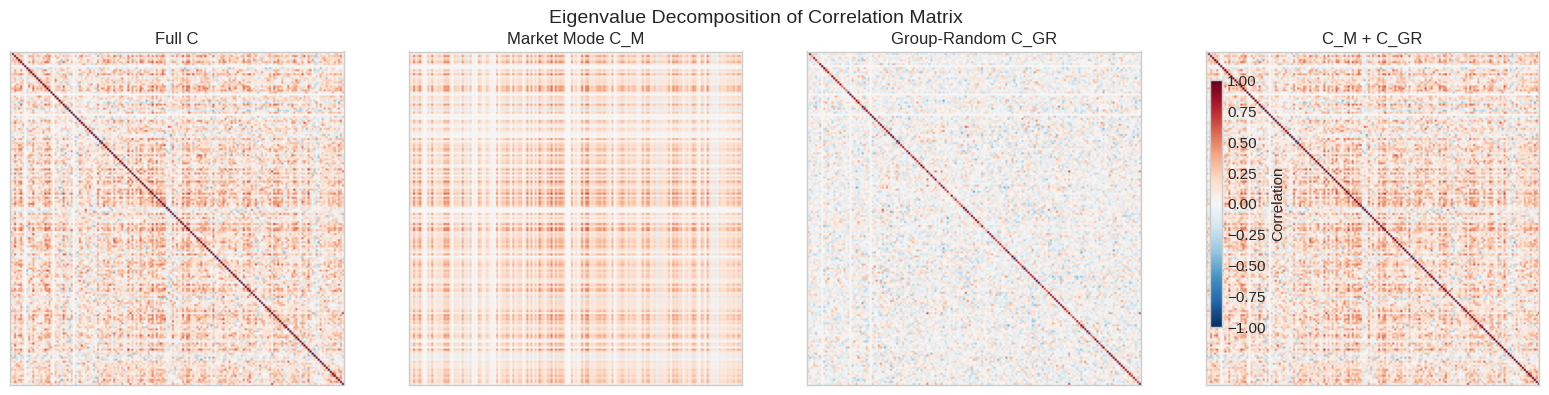

In [88]:
# Visualize correlation matrix and its decomposition
C_M, C_GR, _, _ = decompose_correlation_matrix(C)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = ['Full C', 'Market Mode C_M', 'Group-Random C_GR', 'C_M + C_GR']
matrices = [C, C_M, C_GR, C_M + C_GR]

for ax, title, mat in zip(axes, titles, matrices):
    im = ax.imshow(mat, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

plt.colorbar(im, ax=axes, shrink=0.8, label='Correlation')
plt.suptitle('Eigenvalue Decomposition of Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

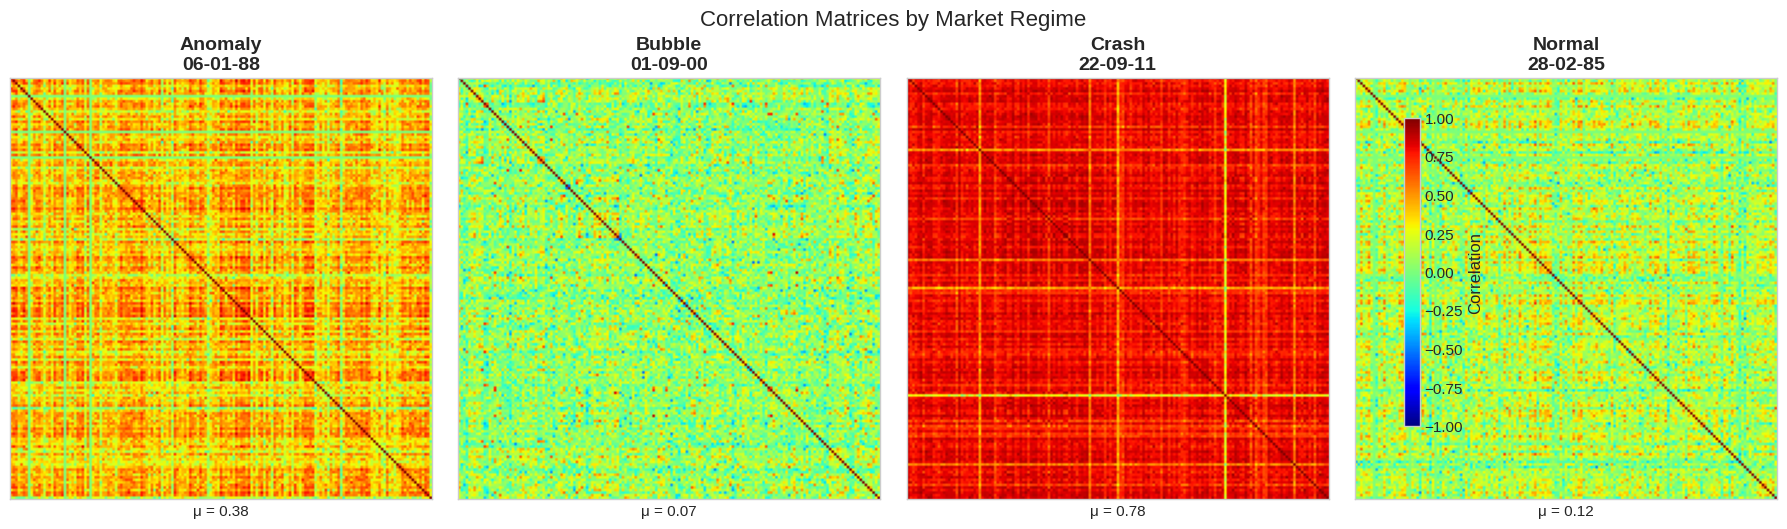

In [89]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Function to get correlation matrix for a specific date
def get_correlation_for_date(target_date, returns_df, epoch_size=40):
    """Get correlation matrix for the epoch ending at target_date"""
    target = pd.Timestamp(target_date)
    
    # Find closest date using searchsorted
    idx = returns_df.index.searchsorted(target)
    end_idx = min(idx, len(returns_df) - 1)
    start_idx = max(0, end_idx - epoch_size + 1)
    
    epoch_returns = returns_df.iloc[start_idx:end_idx+1].values
    C = compute_correlation_matrix(epoch_returns)
    return C, returns_df.index[end_idx]

regime_examples = {
    'Anomaly': '1988-01-06',   # 06-01-88
    'Bubble': '2000-09-01',    # 01-09-00
    'Crash': '2011-09-22',     # 22-09-11
    'Normal': '1985-02-28',    # 28-02-85
}

# Plot each regime's correlation matrix
for ax, (regime, date) in zip(axes, regime_examples.items()):
    try:
        C, actual_date = get_correlation_for_date(date, returns, EPOCH_SIZE)
        
        im = ax.imshow(C, cmap='jet', vmin=-1, vmax=1, aspect='equal')
        
        # Format date as DD-MM-YY
        date_str = actual_date.strftime('%d-%m-%y')
        ax.set_title(f'{regime}\n{date_str}', fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Calculate mean correlation for this epoch
        upper_tri = np.triu_indices(C.shape[0], k=1)
        mu = np.mean(C[upper_tri])
        ax.set_xlabel(f'μ = {mu:.2f}', fontsize=11)
        
    except Exception as e:
        ax.set_title(f'{regime}\n(Error)')
        print(f"Error for {regime}: {e}")

# Add colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8, pad=0.02)
cbar.set_label('Correlation', fontsize=12)

plt.suptitle('Correlation Matrices by Market Regime', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

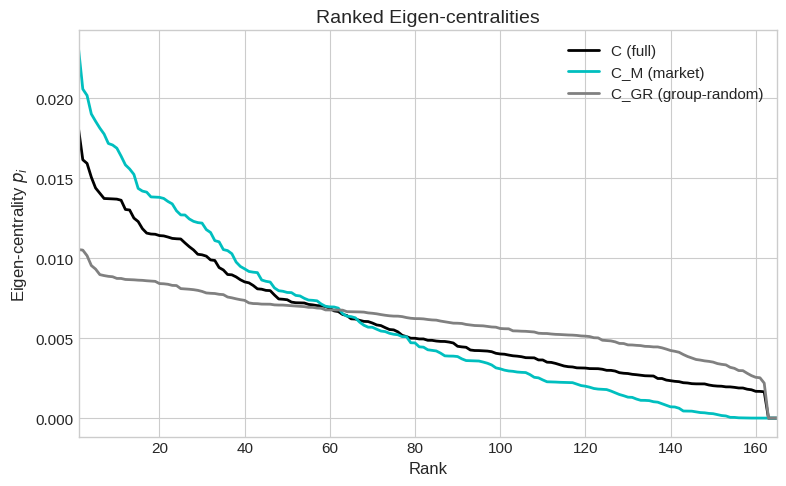

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))

# Get eigen-centralities
A = correlation_to_A_matrix(C)
A_M = correlation_to_A_matrix(C_M)
A_GR = correlation_to_A_matrix(C_GR)

p = compute_eigen_centrality(A)
p_M = compute_eigen_centrality(A_M)
p_GR = compute_eigen_centrality(A_GR)

# Plot ranked 
ranks = np.arange(1, len(p) + 1)
ax.plot(ranks, np.sort(p)[::-1], 'k-', linewidth=2, label='C (full)')
ax.plot(ranks, np.sort(p_M)[::-1], 'c-', linewidth=2, label='C_M (market)')
ax.plot(ranks, np.sort(p_GR)[::-1], 'gray', linewidth=2, label='C_GR (group-random)')

ax.set_xlabel('Rank', fontsize=12)
ax.set_ylabel('Eigen-centrality $p_i$', fontsize=12)
ax.set_title('Ranked Eigen-centralities', fontsize=14)
ax.legend()
ax.set_xlim([1, len(p)])
plt.tight_layout()
plt.show()

---
## Step 4: Rolling Window Analysis

In [91]:
def rolling_window_analysis(returns_df, epoch_size=40, shift=20):
    """
    Rolling window analysis.
    Computes H, H_M, H_GR for each epoch.
    """
    returns = returns_df.values
    dates = returns_df.index
    N = returns.shape[1]
    H_max = np.log(N)  # Wishart limit
    
    results = []
    start = 0
    
    while start + epoch_size <= len(returns):
        epoch_returns = returns[start:start + epoch_size]
        epoch_end_date = dates[start + epoch_size - 1]
        
        # Correlation matrix
        C = compute_correlation_matrix(epoch_returns)
        
        # Three entropies 
        H, H_M, H_GR, eigenvalues = compute_three_entropies(C)
        
        # Mean market correlation μ
        upper_tri = np.triu_indices(N, k=1)
        mu = np.mean(C[upper_tri])
        
        # Phase space coordinates
        H_minus_HM = H - H_M
        H_minus_HGR = H - H_GR
        HM_minus_HGR = H_M - H_GR
        
        # Largest eigenvalue
        lambda_max = eigenvalues[0]
        
        results.append({
            'date': epoch_end_date,
            'H': H,
            'H_M': H_M,
            'H_GR': H_GR,
            'H_max': H_max,
            'H_minus_HM': H_minus_HM,
            'H_minus_HGR': H_minus_HGR,
            'HM_minus_HGR': HM_minus_HGR,
            'abs_H_minus_HM': np.abs(H_minus_HM),
            'abs_H_minus_HGR': np.abs(H_minus_HGR),
            'mu': mu,  # mean correlation
            'lambda_max': lambda_max,
        })
        
        start += shift
        
    return pd.DataFrame(results)

In [92]:
# rolling window analysis
print(f"Running rolling window analysis (M={EPOCH_SIZE}, Δ={SHIFT})...")
results = rolling_window_analysis(returns, epoch_size=EPOCH_SIZE, shift=SHIFT)

print(f"\nAnalyzed {len(results)} epochs")
print(f"Date range: {results['date'].min()} to {results['date'].max()}")
results.head(10)

Running rolling window analysis (M=40, Δ=20)...

Analyzed 515 epochs
Date range: 1985-02-28 00:00:00 to 2025-12-17 00:00:00


date         H       H_M      H_GR     H_max  H_minus_HM  H_minus_HGR  \
0 1985-02-28  4.909705  4.699527  5.045546  5.105945    0.210178    -0.135840   
1 1985-03-28  4.937836  4.687856  5.048248  5.105945    0.249980    -0.110412   
2 1985-04-26  4.947616  4.656005  5.055271  5.105945    0.291611    -0.107655   
3 1985-05-24  4.923958  4.740413  5.046787  5.105945    0.183545    -0.122828   
4 1985-06-24  4.941715  4.762832  5.046569  5.105945    0.178882    -0.104854   
5 1985-07-23  5.001986  4.704518  5.051469  5.105945    0.297467    -0.049483   
6 1985-08-20  4.959337  4.758503  5.050815  5.105945    0.200834    -0.091478   
7 1985-09-18  4.939987  4.752821  5.038649  5.105945    0.187166    -0.098662   
8 1985-10-17  4.924968  4.744956  5.050986  5.105945    0.180011    -0.126018   
9 1985-11-14  4.935267  4.734671  5.051146  5.105945    0.200596    -0.115879   

   HM_minus_HGR  abs_H_minus_HM  abs_H_minus_HGR        mu  lambda_max  
0     -0.346018        0.210178         0.135840  0.122894   29.101423  
1     -0.360392        0.249980         0.110412  0.110789   26.552093  
2     -0.399266        0.291611         0.107655  0.096560   24.305123  
3     -0.306374        0.183545         0.122828  0.135640   30.917470  
4     -0.283736        0.178882         0.104854  0.137894   30.539887  
5     -0.346950        0.297467         0.049483  0.085594   20.904321  
6     -0.292312        0.200834         0.091478  0.128849   28.552390  
7     -0.285828        0.187166         0.098662  0.137196   30.591796  
8     -0.306029        0.180011         0.126018  0.140745   30.660802  
9     -0.316475        0.200596         0.115879  0.132712   29.384289

---
## Step 5: Regime Identification


In [93]:
MARKET_EVENTS = {
    'crashes': [
        # Pre-2000 events
        ('1987-10-19', '1987-10-30', 'Black Monday'),
        ('1989-10-13', '1989-10-20', 'Friday 13th Mini Crash'),
        ('1990-01-01', '1990-12-31', 'Early 90s Recession'),
        ('1997-10-27', '1997-11-15', 'Asian Financial Crisis'),
        # 2000s events
        ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
        ('2001-09-11', '2001-09-30', '9/11 Financial Crisis'),
        ('2002-09-01', '2002-10-15', 'Stock Market Downturn 2002'),
        ('2008-09-15', '2008-11-30', 'Lehman Brothers Crash'),
        ('2010-05-06', '2010-05-20', 'DJ Flash Crash'),
        ('2011-03-11', '2011-03-25', 'Tsunami/Fukushima'),
        ('2011-08-08', '2011-08-31', 'August 2011 Markets Fall'),
        ('2015-08-24', '2015-09-15', 'Chinese Black Monday'),
        ('2018-02-02', '2018-02-09', 'Volatility spike'),
        ('2020-02-20', '2020-03-23', 'COVID Crash'),
    ],
    'bubbles': [
        ('1999-01-01', '2000-03-09', 'Dot-com Bubble'),
        ('2005-01-01', '2007-10-01', 'US Housing Bubble'),
        ('2021-01-01', '2021-11-15', 'Post-COVID Rally'),
    ]
}

print(f"Total crash events: {len(MARKET_EVENTS['crashes'])}")
print(f"Total bubble events: {len(MARKET_EVENTS['bubbles'])}")

Total crash events: 14
Total bubble events: 3


In [94]:
def identify_regimes(df, events):
    """Label epochs based on known market events."""
    df = df.copy()
    df['regime'] = 'normal'
    df['event_name'] = ''
    
    for start, end, name in events['crashes']:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'regime'] = 'crash'
        df.loc[mask, 'event_name'] = name
    
    for start, end, name in events['bubbles']:
        mask = (df['date'] >= start) & (df['date'] <= end)
        df.loc[mask, 'regime'] = 'bubble'
        df.loc[mask, 'event_name'] = name
    
    # Type-1 events: High |H - H_M| AND high |H - H_GR| (far from origin)
    # Type-2 events: Near one axis (anomalies near crashes)
    threshold_HM = df['abs_H_minus_HM'].quantile(0.90)
    threshold_HGR = df['abs_H_minus_HGR'].quantile(0.90)
    
    type1_mask = (df['abs_H_minus_HM'] > threshold_HM) & \
                 (df['abs_H_minus_HGR'] > threshold_HGR) & \
                 (df['regime'] == 'normal')
    df.loc[type1_mask, 'regime'] = 'type-1'
    
    return df

results = identify_regimes(results, MARKET_EVENTS)
print("Regime Distribution:")
print(results['regime'].value_counts())

Regime Distribution:
regime
normal    430
bubble     60
crash      24
type-1      1
Name: count, dtype: int64


---
## Step 6: Figures

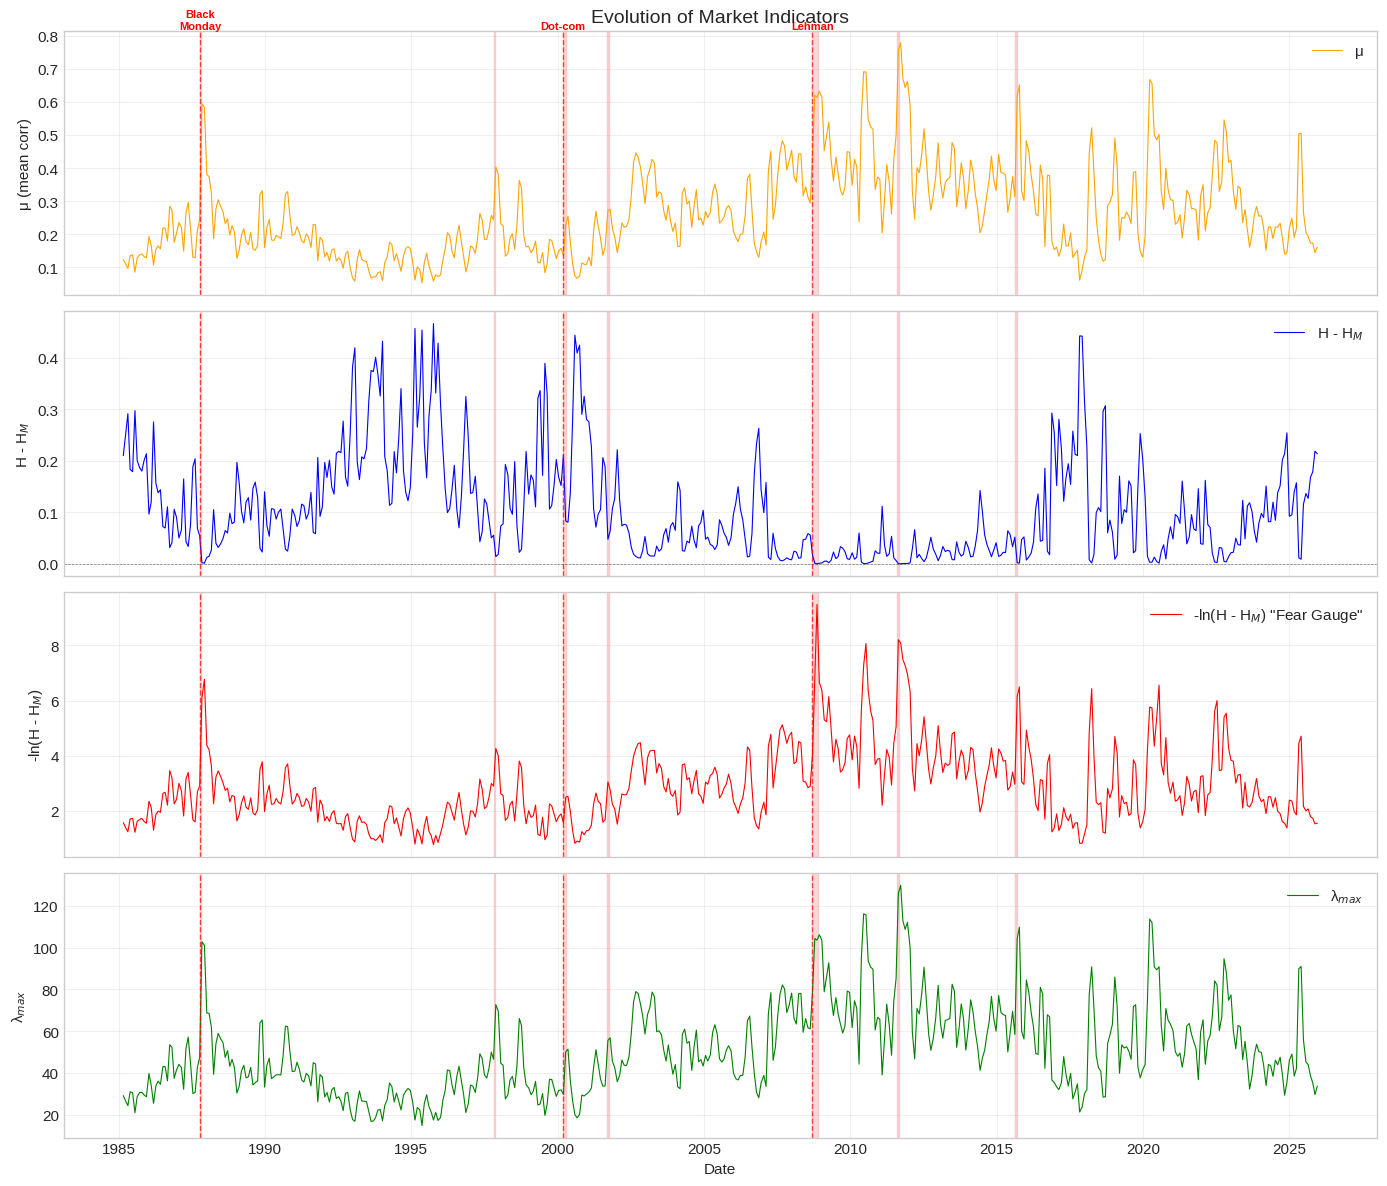

In [95]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Crisis periods
crisis_periods = [
    ('1987-10-19', '1987-10-30', 'Black Monday'),
    ('1997-10-27', '1997-11-15', 'Asian Crisis'),
    ('2000-03-10', '2000-04-14', 'Dot-com Crash'),
    ('2001-09-11', '2001-09-30', '9/11'),
    ('2008-09-15', '2008-11-30', 'Lehman'),
    ('2011-08-08', '2011-08-31', 'Aug 2011'),
    ('2015-08-24', '2015-09-15', 'China'),
]

# Panel 1: Mean correlation μ
ax = axes[0]
ax.plot(results['date'], results['mu'], color='orange', linewidth=0.8, label='μ')
ax.set_ylabel('μ (mean corr)', fontsize=11)
ax.set_title('Evolution of Market Indicators', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: H - H_M
ax = axes[1]
ax.plot(results['date'], results['H_minus_HM'], color='blue', linewidth=0.8, label='H - H$_M$')
ax.set_ylabel('H - H$_M$', fontsize=11)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 3: -ln(H - H_M) - "fear gauge" similar to VIX
ax = axes[2]
neg_ln = -np.log(results['H_minus_HM'].clip(lower=1e-10))
ax.plot(results['date'], neg_ln, color='red', linewidth=0.8, label='-ln(H - H$_M$) "Fear Gauge"')
ax.set_ylabel('-ln(H - H$_M$)', fontsize=11)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 4: Largest eigenvalue
ax = axes[3]
ax.plot(results['date'], results['lambda_max'], color='green', linewidth=0.8, label='λ$_{max}$')
ax.set_ylabel('λ$_{max}$', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

crisis_added = False
for ax in axes:
    for start, end, name in crisis_periods:
        try:
            if not crisis_added:
                ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                          color='lightcoral', alpha=0.3, label='Crisis Period')
                crisis_added = True
            else:
                ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), 
                          color='lightcoral', alpha=0.3)
        except:
            pass
    crisis_added = False  

# Add vertical lines for major crashes with labels 
major_crashes = [
    ('1987-10-19', 'Black\nMonday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]

for date, label in major_crashes:
    try:
        for ax in axes:
            ax.axvline(pd.Timestamp(date), color='red', linestyle='--', linewidth=1, alpha=0.7)
        # Add label only to top panel
        axes[0].annotate(label, xy=(pd.Timestamp(date), axes[0].get_ylim()[1]), 
                        fontsize=8, ha='center', va='bottom', color='red', fontweight='bold')
    except:
        pass

plt.tight_layout()
plt.show()


Scaling fit: (H - H_M) ~ 0.778 * exp(-9.76 * μ)
Paper values: α ≈ 0.85, β ≈ 10.22


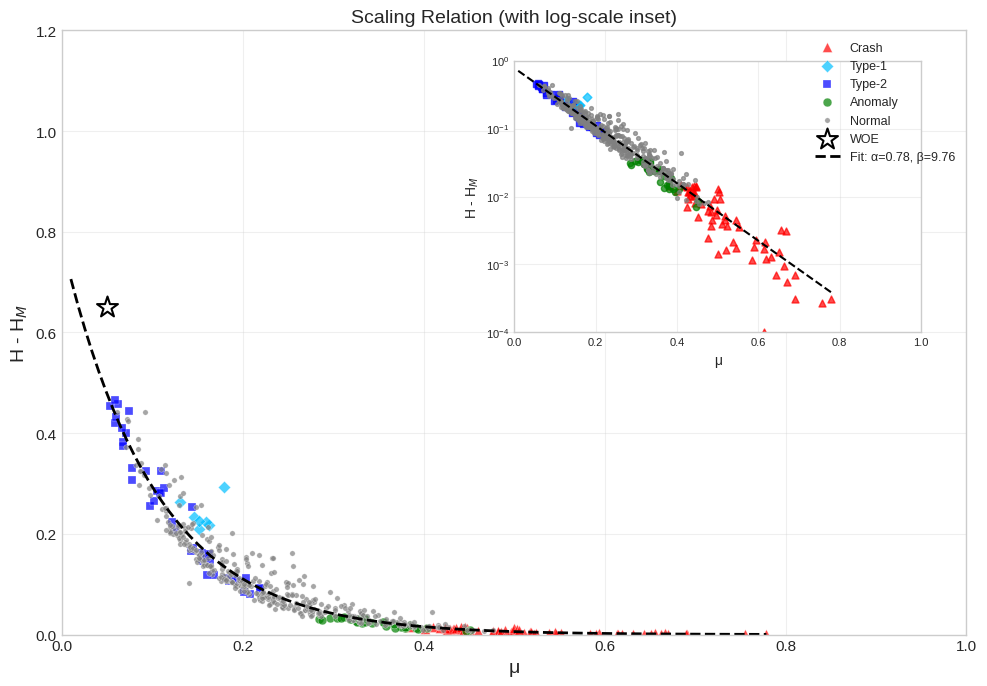

In [96]:
fig, ax = plt.subplots(figsize=(10, 7))

# Use phase-space-based regimes for coloring
results_plot = results.copy()

H_HM_low = results_plot['abs_H_minus_HM'].quantile(0.15)
H_HM_high = results_plot['abs_H_minus_HM'].quantile(0.85)
H_HGR_low = results_plot['abs_H_minus_HGR'].quantile(0.15)
H_HGR_high = results_plot['abs_H_minus_HGR'].quantile(0.85)

results_plot['phase_regime'] = 'Normal'

crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_low) & \
             (results_plot['abs_H_minus_HGR'] > results_plot['abs_H_minus_HGR'].quantile(0.5))
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'

type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_high) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_high)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'

type2_mask = (results_plot['abs_H_minus_HM'] > results_plot['abs_H_minus_HM'].quantile(0.5)) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_low)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'

anomaly_mask = (results_plot['abs_H_minus_HM'] < results_plot['abs_H_minus_HM'].quantile(0.3)) & \
               (results_plot['abs_H_minus_HGR'] < results_plot['abs_H_minus_HGR'].quantile(0.3))
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

MARKERS = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 15),
}

# Plot colored by regime
for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'mu'], 
                  results_plot.loc[mask, 'H_minus_HM'],
                  marker=marker, c=color, s=size, label=regime,
                  alpha=0.7, edgecolors='white', linewidth=0.3)

# WOE reference point (high μ, H-H_M ≈ 0)
ax.scatter([0.05], [0.65], c='white', marker='*', s=250, 
           edgecolors='black', linewidth=1.5, label='WOE', zorder=5)

# Exponential fit: (H - H_M) ~ α * exp(-β * μ)
def exp_func(x, alpha, beta):
    return alpha * np.exp(-beta * x)

try:
    mask = (results_plot['H_minus_HM'] > 0.001) & (results_plot['mu'] > 0.01)
    x_data = results_plot.loc[mask, 'mu'].values
    y_data = results_plot.loc[mask, 'H_minus_HM'].values
    
    popt, pcov = curve_fit(exp_func, x_data, y_data, p0=[0.85, 10], maxfev=10000)
    
    x_fit = np.linspace(0.01, results_plot['mu'].max(), 100)
    y_fit = exp_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'k--', linewidth=2, 
            label=f'Fit: α={popt[0]:.2f}, β={popt[1]:.2f}')
    
    print(f"Scaling fit: (H - H_M) ~ {popt[0]:.3f} * exp(-{popt[1]:.2f} * μ)")
    print(f"Paper values: α ≈ 0.85, β ≈ 10.22")
except Exception as e:
    print(f"Fit failed: {e}")

ax.set_xlabel('μ', fontsize=14)
ax.set_ylabel('H - H$_M$', fontsize=14)
ax.set_title('Scaling Relation (with log-scale inset)', fontsize=14)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.2])

# Add inset with log scale 
inset = ax.inset_axes([0.5, 0.5, 0.45, 0.45])

for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        inset.scatter(results_plot.loc[mask, 'mu'], 
                     results_plot.loc[mask, 'H_minus_HM'].clip(lower=1e-4),
                     marker=marker, c=color, s=size*0.5, alpha=0.7)

# Add fit line to inset
if 'popt' in dir():
    inset.plot(x_fit, y_fit, 'k--', linewidth=1.5)

inset.set_yscale('log')
inset.set_xlabel('μ', fontsize=10)
inset.set_ylabel('H - H$_M$', fontsize=10)
inset.set_xlim([0, 1])
inset.set_ylim([1e-4, 1e0])
inset.tick_params(labelsize=8)
inset.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

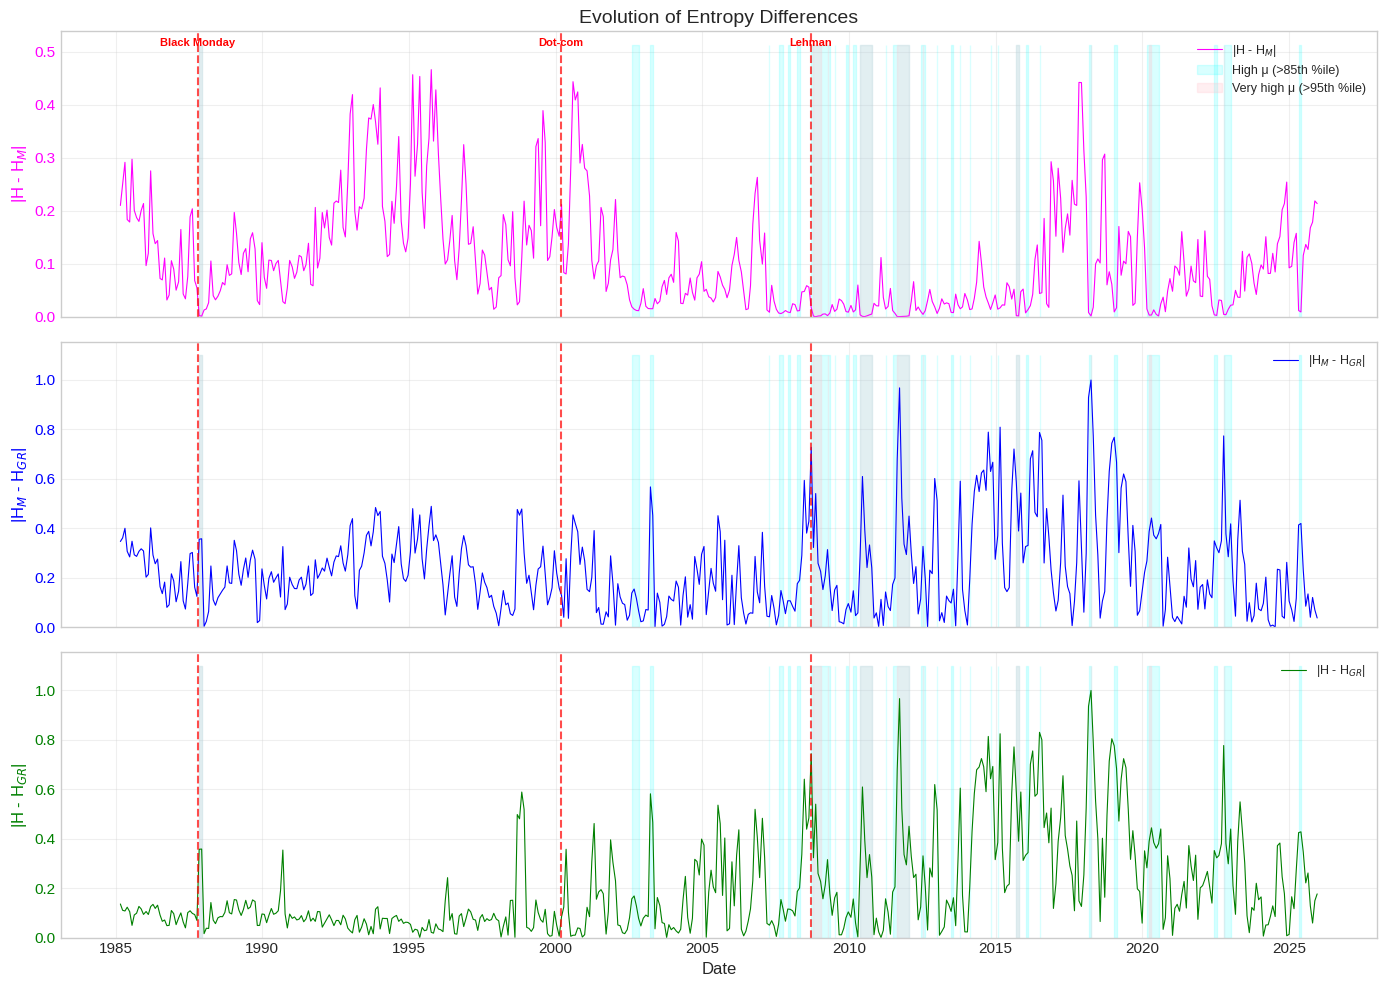

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Define high correlation periods for colored bands
high_corr_threshold = results['mu'].quantile(0.85)
very_high_corr = results['mu'].quantile(0.95)

high_corr_mask = results['mu'] > high_corr_threshold
very_high_corr_mask = results['mu'] > very_high_corr

# Major crash dates for vertical lines
crash_dates = [
    ('1987-10-19', 'Black Monday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]

# Panel 1: |H - H_M| 
ax = axes[0]
ax.plot(results['date'], results['abs_H_minus_HM'], color='magenta', linewidth=0.8, label='|H - H$_M$|')
ax.fill_between(results['date'], 0, results['abs_H_minus_HM'].max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan', label='High μ (>85th %ile)')
ax.fill_between(results['date'], 0, results['abs_H_minus_HM'].max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink', label='Very high μ (>95th %ile)')
ax.set_ylabel('|H - H$_M$|', fontsize=12, color='magenta')
ax.set_title('Evolution of Entropy Differences', fontsize=14)
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='magenta')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: |H_M - H_GR| 
ax = axes[1]
ax.plot(results['date'], results['HM_minus_HGR'].abs(), color='blue', linewidth=0.8, label='|H$_M$ - H$_{GR}$|')
ax.fill_between(results['date'], 0, results['HM_minus_HGR'].abs().max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan')
ax.fill_between(results['date'], 0, results['HM_minus_HGR'].abs().max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink')
ax.set_ylabel('|H$_M$ - H$_{GR}$|', fontsize=12, color='blue')
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='blue')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: |H - H_GR| 
ax = axes[2]
ax.plot(results['date'], results['abs_H_minus_HGR'], color='green', linewidth=0.8, label='|H - H$_{GR}$|')
ax.fill_between(results['date'], 0, results['abs_H_minus_HGR'].max() * 1.1,
                where=high_corr_mask, alpha=0.15, color='cyan')
ax.fill_between(results['date'], 0, results['abs_H_minus_HGR'].abs().max() * 1.1,
                where=very_high_corr_mask, alpha=0.25, color='pink')
ax.set_ylabel('|H - H$_{GR}$|', fontsize=12, color='green')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylim(bottom=0)
ax.tick_params(axis='y', labelcolor='green')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Add crash markers with labels
for ax_idx, ax in enumerate(axes):
    for cd, name in crash_dates:
        try:
            ax.axvline(pd.Timestamp(cd), color='red', linestyle='--', alpha=0.7, linewidth=1.5)
            # Add label 
            if ax_idx == 0:
                ax.annotate(name, xy=(pd.Timestamp(cd), ax.get_ylim()[1]*0.95), 
                           fontsize=8, ha='center', color='red', fontweight='bold')
        except:
            pass

plt.tight_layout()
plt.show()


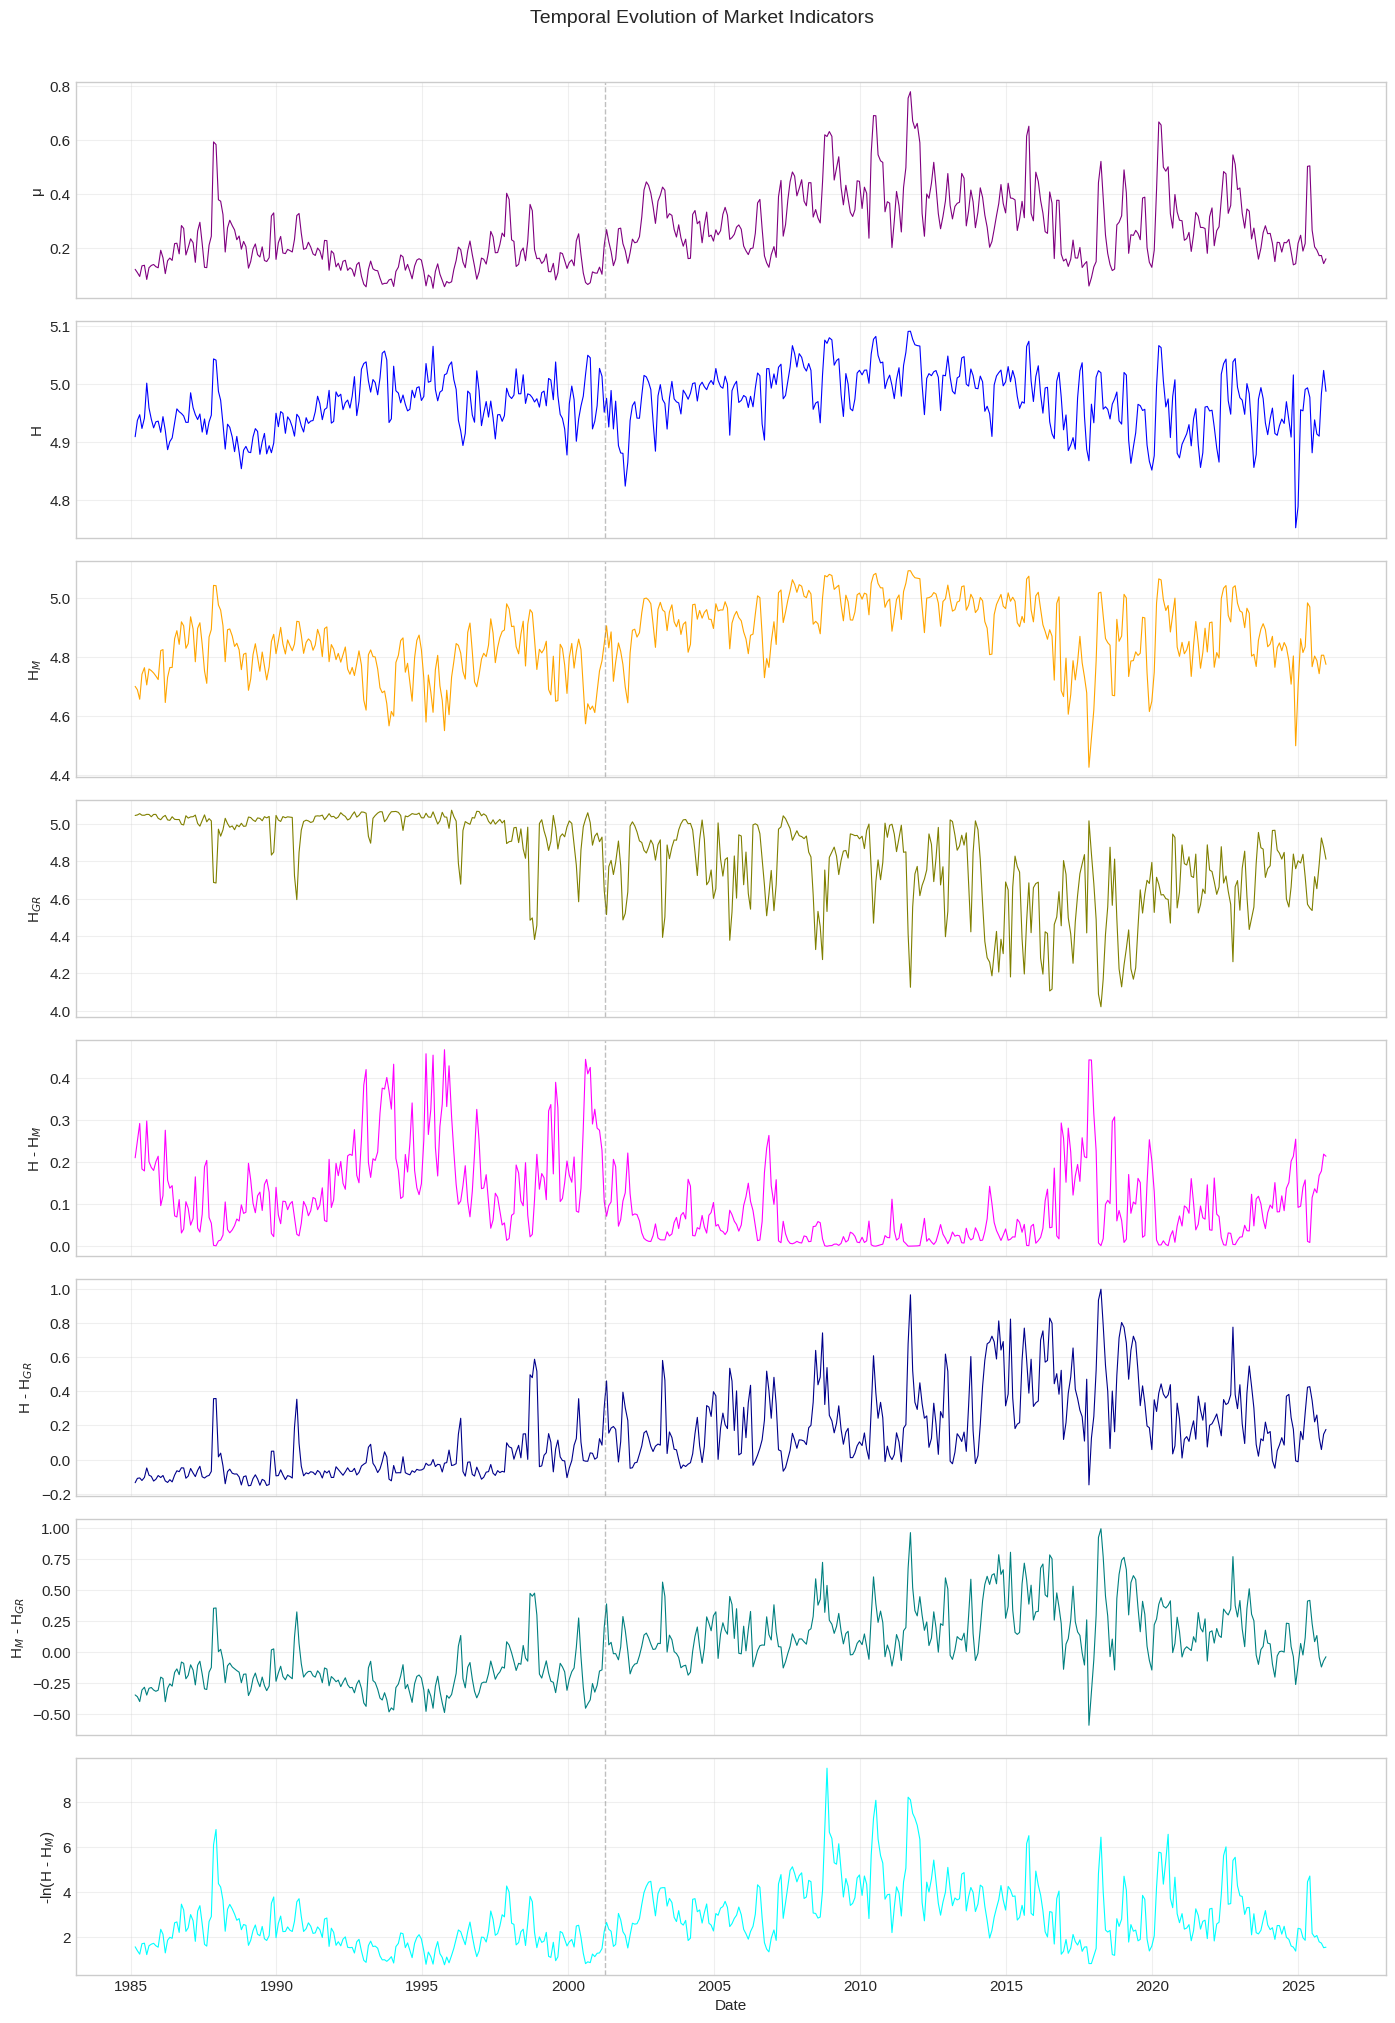

In [98]:
fig, axes = plt.subplots(8, 1, figsize=(14, 20), sharex=True)

plot_data = [
    ('mu', 'μ', 'purple'),
    ('H', 'H', 'blue'),
    ('H_M', 'H$_M$', 'orange'),
    ('H_GR', 'H$_{GR}$', 'olive'),
    ('H_minus_HM', 'H - H$_M$', 'magenta'),
    ('H_minus_HGR', 'H - H$_{GR}$', 'darkblue'),
    ('HM_minus_HGR', 'H$_M$ - H$_{GR}$', 'teal'),
]

# Plot first 7 variables
for ax, (col, label, color) in zip(axes[:7], plot_data):
    ax.plot(results['date'], results[col], color=color, linewidth=0.8)
    ax.set_ylabel(label, fontsize=11)
    ax.grid(True, alpha=0.3)

# Panel 8: -ln(H - H_M) - the fear gauge
ax = axes[7]
neg_ln_H = -np.log(results['H_minus_HM'].clip(lower=1e-10))
ax.plot(results['date'], neg_ln_H, color='cyan', linewidth=0.8)
ax.set_ylabel('-ln(H - H$_M$)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.grid(True, alpha=0.3)

for ax in axes:
    ax.axvline(pd.Timestamp('2001-04-01'), color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.suptitle('Temporal Evolution of Market Indicators', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

DETAILED TRANSITION ANALYSIS

Phase Space Regions:
  CRASH (top-left):    |H-H_M| < 0.0262 AND |H-H_GR| > 0.1155
  ANOMALY (bot-left):  |H-H_M| < 0.0452 AND |H-H_GR| < 0.0813
  TYPE-1 (top-right):  |H-H_M| > 0.1791 AND |H-H_GR| > 0.3572
  TYPE-2 (bot-right):  |H-H_M| > 0.0781 AND |H-H_GR| < 0.0507

Black Monday (1987-10-19): CRASH TRANSITION
  Sequence: Normal → Normal → Normal → Normal → Crash → Crash → Anomaly
  Event values: |H-H_M|=0.0548, |H-H_GR|=0.0695

Asian Crisis (1997-10-27): ANOMALY TRANSITION
  Sequence: Normal → Normal → Normal → Normal → Normal → Anomaly → Normal
  Event values: |H-H_M|=0.0556, |H-H_GR|=0.0731

Dot-com Crash (2000-03-10): TYPE TRANSITION
  Sequence: Normal → Type-2 → Type-2 → Normal → Normal → Normal → Normal
  Event values: |H-H_M|=0.2121, |H-H_GR|=0.0841

9/11 (2001-09-11): NO CLEAR TRANSITION
  Sequence: Normal → Normal → Normal → Normal → Normal → Normal → Normal
  Event values: |H-H_M|=0.0478, |H-H_GR|=0.0142

Lehman (2008-09-15): CRASH TRANSITION
 

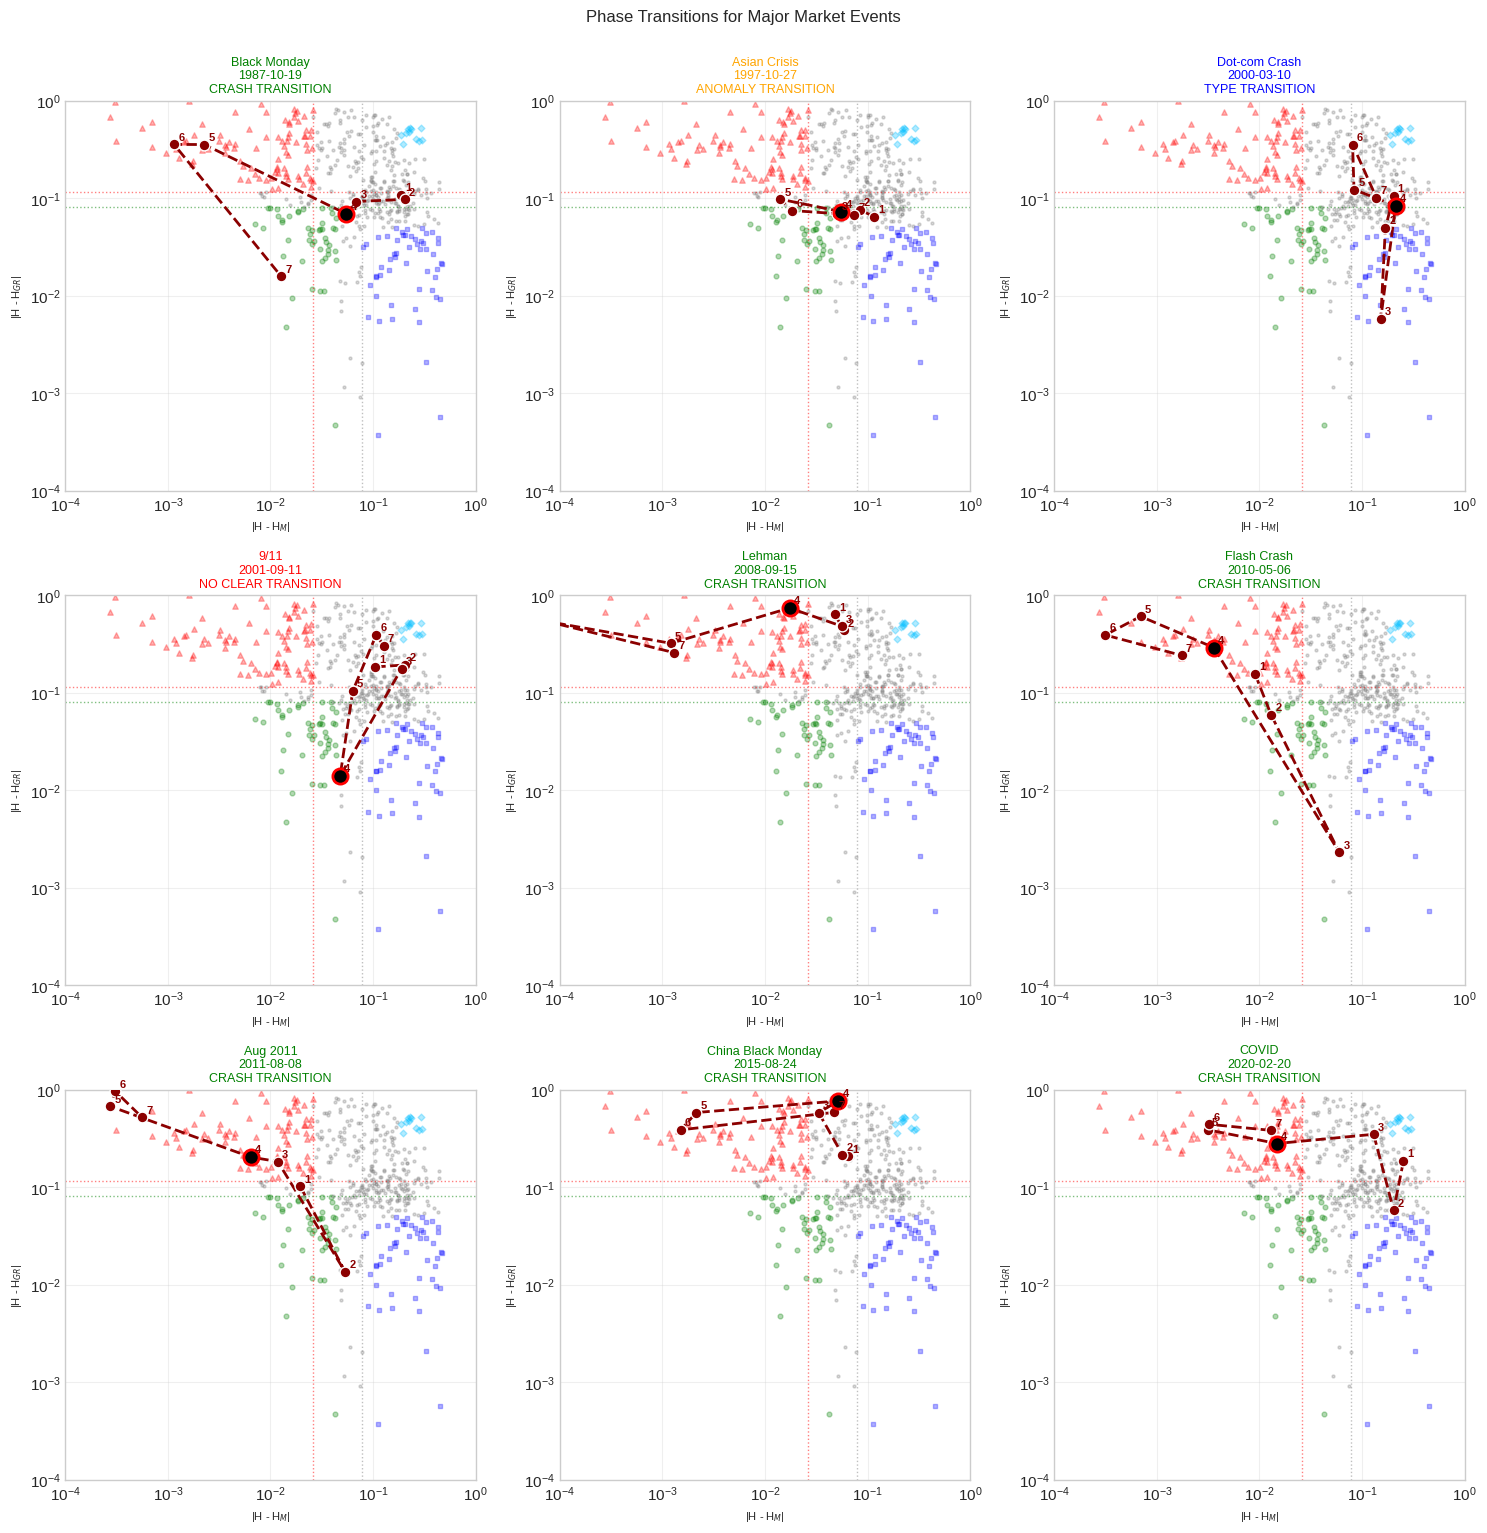

In [99]:
results_plot = results.copy()
results_plot = results_plot.reset_index(drop=True)

H_HM_25 = results_plot['abs_H_minus_HM'].quantile(0.25)
H_HM_35 = results_plot['abs_H_minus_HM'].quantile(0.35)
H_HM_50 = results_plot['abs_H_minus_HM'].quantile(0.50)
H_HM_80 = results_plot['abs_H_minus_HM'].quantile(0.80)
H_HGR_20 = results_plot['abs_H_minus_HGR'].quantile(0.20)
H_HGR_35 = results_plot['abs_H_minus_HGR'].quantile(0.35)
H_HGR_50 = results_plot['abs_H_minus_HGR'].quantile(0.50)
H_HGR_80 = results_plot['abs_H_minus_HGR'].quantile(0.80)

results_plot['phase_regime'] = 'Normal'

crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_25) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_50)
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'

type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_80) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_80)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'

type2_mask = (results_plot['abs_H_minus_HM'] > H_HM_50) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_20)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'

anomaly_mask = (results_plot['abs_H_minus_HM'] < H_HM_35) & \
               (results_plot['abs_H_minus_HGR'] < H_HGR_35) & \
               (results_plot['phase_regime'] == 'Normal')
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

def get_event_sequence(df, event_date, n_before=3, n_after=3):
    event_ts = pd.Timestamp(event_date)
    date_diffs = (df['date'] - event_ts).abs()
    event_idx = date_diffs.idxmin()
    start_idx = max(0, event_idx - n_before)
    end_idx = min(len(df) - 1, event_idx + n_after)
    return df.iloc[start_idx:end_idx + 1].copy(), event_idx - start_idx

def classify_transition(seq):
    regimes = seq['phase_regime'].tolist()
    has_crash = 'Crash' in regimes
    has_anomaly = 'Anomaly' in regimes
    has_normal = 'Normal' in regimes
    has_type1 = 'Type-1' in regimes
    has_type2 = 'Type-2' in regimes
    
    if has_crash and (has_normal or has_anomaly):
        return "CRASH TRANSITION", "green"
    elif has_anomaly and has_normal and not has_crash:
        return "ANOMALY TRANSITION", "orange"
    elif has_type1 or has_type2:
        return "TYPE TRANSITION", "blue"
    else:
        return "NO CLEAR TRANSITION", "red"

CRASH_EVENTS = [
    ('1987-10-19', 'Black Monday'),
    ('1997-10-27', 'Asian Crisis'),
    ('2000-03-10', 'Dot-com Crash'),
    ('2001-09-11', '9/11'),
    ('2008-09-15', 'Lehman'),
    ('2010-05-06', 'Flash Crash'),
    ('2011-08-08', 'Aug 2011'),
    ('2015-08-24', 'China Black Monday'),
    ('2020-02-20', 'COVID'),
]

print("="*90)
print("DETAILED TRANSITION ANALYSIS")
print("="*90)
print(f"\nPhase Space Regions:")
print(f"  CRASH (top-left):    |H-H_M| < {H_HM_25:.4f} AND |H-H_GR| > {H_HGR_50:.4f}")
print(f"  ANOMALY (bot-left):  |H-H_M| < {H_HM_35:.4f} AND |H-H_GR| < {H_HGR_35:.4f}")
print(f"  TYPE-1 (top-right):  |H-H_M| > {H_HM_80:.4f} AND |H-H_GR| > {H_HGR_80:.4f}")
print(f"  TYPE-2 (bot-right):  |H-H_M| > {H_HM_50:.4f} AND |H-H_GR| < {H_HGR_20:.4f}")

for event_date, event_name in CRASH_EVENTS:
    seq, event_pos = get_event_sequence(results_plot, event_date)
    transition_type, color = classify_transition(seq)
    regimes = seq['phase_regime'].tolist()
    
    print(f"\n{event_name} ({event_date}): {transition_type}")
    print(f"  Sequence: {' → '.join(regimes)}")
    
    event_row = seq.iloc[event_pos]
    print(f"  Event values: |H-H_M|={event_row['abs_H_minus_HM']:.4f}, |H-H_GR|={event_row['abs_H_minus_HGR']:.4f}")

MARKERS = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 15),
}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, (event_date, event_name) in enumerate(CRASH_EVENTS):
    ax = axes[idx]
    
    for regime, (marker, color, size) in MARKERS.items():
        mask = results_plot['phase_regime'] == regime
        if mask.any():
            ax.scatter(results_plot.loc[mask, 'abs_H_minus_HM'] + 1e-6,
                      results_plot.loc[mask, 'abs_H_minus_HGR'] + 1e-6,
                      marker=marker, c=color, s=size*0.3, alpha=0.3, zorder=1)
    
    ax.axvline(H_HM_25, color='red', linestyle=':', alpha=0.5, linewidth=1)
    ax.axvline(H_HM_50, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax.axhline(H_HGR_50, color='red', linestyle=':', alpha=0.5, linewidth=1)
    ax.axhline(H_HGR_35, color='green', linestyle=':', alpha=0.5, linewidth=1)
    
    seq, event_pos = get_event_sequence(results_plot, event_date)
    x = seq['abs_H_minus_HM'].values + 1e-6
    y = seq['abs_H_minus_HGR'].values + 1e-6
    
    transition_type, title_color = classify_transition(seq)
    
    ax.plot(x, y, '--', color='darkred', linewidth=2, zorder=4)
    ax.scatter(x, y, c='darkred', s=60, zorder=5, edgecolors='white', linewidth=1)
    ax.scatter(x[event_pos], y[event_pos], c='black', s=120, zorder=6, edgecolors='red', linewidth=2)
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.annotate(str(i+1), (xi, yi), fontsize=8, fontweight='bold',
                   color='darkred', xytext=(3, 3), textcoords='offset points', zorder=7)
    
    ax.set_title(f'{event_name}\n{event_date}\n{transition_type}', fontsize=9, color=title_color)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([1e-4, 1e0])
    ax.set_ylim([1e-4, 1e0])
    ax.set_xlabel('|H - H$_M$|', fontsize=8)
    ax.set_ylabel('|H - H$_{GR}$|', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Phase Transitions for Major Market Events', 
             fontsize=12, y=1.02)
plt.show()



RED: Crash Transition (1987-07-16 to 1988-01-06)
     Event date: 1987-10-09
         date phase_regime  abs_H_minus_HM  abs_H_minus_HGR
30 1987-07-16       Normal        0.188627         0.108386
31 1987-08-13       Normal        0.203894         0.097823
32 1987-09-11       Normal        0.068401         0.093034
33 1987-10-09       Normal        0.054809         0.069511
34 1987-11-06        Crash        0.002267         0.357146
35 1987-12-07        Crash        0.001147         0.358109
36 1988-01-06      Anomaly        0.012684         0.015923

BLUE: Type-1→Type-2 Transition (1998-09-10 to 1999-03-04)
      Event date: 1998-12-04
          date phase_regime  abs_H_minus_HM  abs_H_minus_HGR
171 1998-09-10        Crash        0.022369         0.497612
172 1998-10-08       Normal        0.028338         0.480422
173 1998-11-05       Normal        0.111491         0.588641
174 1998-12-04       Type-1        0.218315         0.518359
175 1999-01-05       Type-2        0.135514       

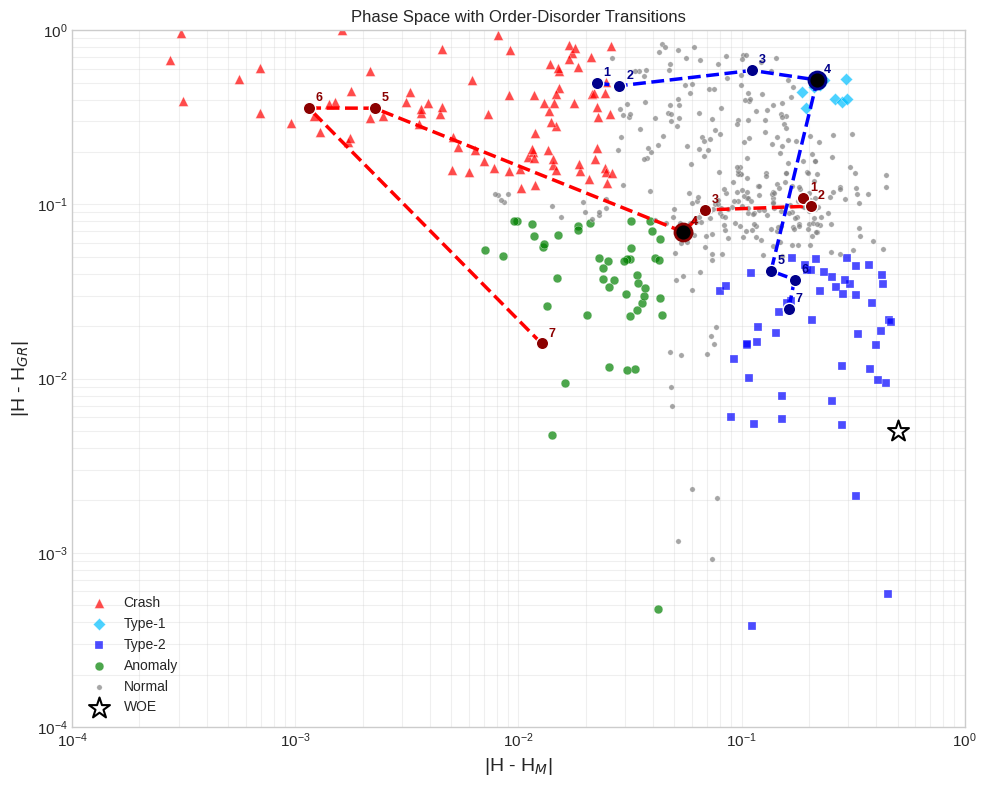

In [100]:
results_plot = results.copy()
results_plot = results_plot.reset_index(drop=True)

# Compute thresholds
H_HM_25 = results_plot['abs_H_minus_HM'].quantile(0.25)
H_HM_35 = results_plot['abs_H_minus_HM'].quantile(0.35)
H_HM_50 = results_plot['abs_H_minus_HM'].quantile(0.50)
H_HM_80 = results_plot['abs_H_minus_HM'].quantile(0.80)
H_HGR_20 = results_plot['abs_H_minus_HGR'].quantile(0.20)
H_HGR_35 = results_plot['abs_H_minus_HGR'].quantile(0.35)
H_HGR_50 = results_plot['abs_H_minus_HGR'].quantile(0.50)
H_HGR_80 = results_plot['abs_H_minus_HGR'].quantile(0.80)

# Classify regimes
results_plot['phase_regime'] = 'Normal'
results_plot.loc[(results_plot['abs_H_minus_HM'] < H_HM_25) & 
                 (results_plot['abs_H_minus_HGR'] > H_HGR_50), 'phase_regime'] = 'Crash'
results_plot.loc[(results_plot['abs_H_minus_HM'] > H_HM_80) & 
                 (results_plot['abs_H_minus_HGR'] > H_HGR_80), 'phase_regime'] = 'Type-1'
results_plot.loc[(results_plot['abs_H_minus_HM'] > H_HM_50) & 
                 (results_plot['abs_H_minus_HGR'] < H_HGR_20), 'phase_regime'] = 'Type-2'
results_plot.loc[(results_plot['abs_H_minus_HM'] < H_HM_35) & 
                 (results_plot['abs_H_minus_HGR'] < H_HGR_35) & 
                 (results_plot['phase_regime'] == 'Normal'), 'phase_regime'] = 'Anomaly'


crash_date_1987 = pd.Timestamp('1987-10-19')
best_red_idx = (results_plot['date'] - crash_date_1987).abs().idxmin()

best_blue_idx = None
best_blue_score = 0

for i in range(3, len(results_plot) - 3):
    seq = results_plot.iloc[i-3:i+4]
    regimes = seq['phase_regime'].tolist()
    
    has_type1 = 'Type-1' in regimes
    has_type2 = 'Type-2' in regimes
    
    if has_type1 and has_type2:
        t1_pos = [j for j, r in enumerate(regimes) if r == 'Type-1']
        t2_pos = [j for j, r in enumerate(regimes) if r == 'Type-2']
        
        if min(t1_pos) < max(t2_pos):
            drop = seq['abs_H_minus_HGR'].iloc[0] - seq['abs_H_minus_HGR'].iloc[-1]
            if drop > best_blue_score:
                best_blue_score = drop
                best_blue_idx = i

# Extract sequences
red_seq = results_plot.iloc[best_red_idx-3:best_red_idx+4]
blue_seq = results_plot.iloc[best_blue_idx-3:best_blue_idx+4]

# Get event dates
red_event_date = results_plot.iloc[best_red_idx]['date'].strftime('%Y-%m-%d')
blue_event_date = results_plot.iloc[best_blue_idx]['date'].strftime('%Y-%m-%d')

red_start = red_seq.iloc[0]['date'].strftime('%Y-%m-%d')
red_end = red_seq.iloc[-1]['date'].strftime('%Y-%m-%d')
blue_start = blue_seq.iloc[0]['date'].strftime('%Y-%m-%d')
blue_end = blue_seq.iloc[-1]['date'].strftime('%Y-%m-%d')

print("="*80)
print(f"RED: Crash Transition ({red_start} to {red_end})")
print(f"     Event date: {red_event_date}")
print("="*80)
print(red_seq[['date', 'phase_regime', 'abs_H_minus_HM', 'abs_H_minus_HGR']])

print(f"\n{'='*80}")
print(f"BLUE: Type-1→Type-2 Transition ({blue_start} to {blue_end})")
print(f"      Event date: {blue_event_date}")
print("="*80)
print(blue_seq[['date', 'phase_regime', 'abs_H_minus_HM', 'abs_H_minus_HGR']])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

MARKERS = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 15),
}

for regime, (marker, color, size) in MARKERS.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'abs_H_minus_HM'] + 1e-6,
                  results_plot.loc[mask, 'abs_H_minus_HGR'] + 1e-6,
                  marker=marker, c=color, s=size, label=regime,
                  alpha=0.7, edgecolors='white', linewidth=0.3, zorder=2)

ax.scatter([0.5], [0.005], c='white', marker='*', s=250, 
           edgecolors='black', linewidth=1.5, label='WOE', zorder=5)

# RED sequence
x_red = red_seq['abs_H_minus_HM'].values + 1e-6
y_red = red_seq['abs_H_minus_HGR'].values + 1e-6
ax.plot(x_red, y_red, 'r--', linewidth=2.5, zorder=4)
ax.scatter(x_red, y_red, c='darkred', s=80, zorder=5, edgecolors='white', linewidth=1)
ax.scatter(x_red[3], y_red[3], c='black', s=150, zorder=6, edgecolors='darkred', linewidth=2)
for i, (xi, yi) in enumerate(zip(x_red, y_red)):
    ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
               color='darkred', xytext=(5, 5), textcoords='offset points', zorder=7)

# BLUE sequence
x_blue = blue_seq['abs_H_minus_HM'].values + 1e-6
y_blue = blue_seq['abs_H_minus_HGR'].values + 1e-6
ax.plot(x_blue, y_blue, 'b--', linewidth=2.5, zorder=4)
ax.scatter(x_blue, y_blue, c='darkblue', s=80, zorder=5, edgecolors='white', linewidth=1)
ax.scatter(x_blue[3], y_blue[3], c='black', s=150, zorder=6, edgecolors='darkblue', linewidth=2)
for i, (xi, yi) in enumerate(zip(x_blue, y_blue)):
    ax.annotate(str(i+1), (xi, yi), fontsize=9, fontweight='bold',
               color='darkblue', xytext=(5, 5), textcoords='offset points', zorder=7)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('|H - H$_M$|', fontsize=14)
ax.set_ylabel('|H - H$_{GR}$|', fontsize=14)
ax.set_title(f'Phase Space with Order-Disorder Transitions', fontsize=12)
ax.legend(loc='lower left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1e-4, 1e0])
ax.set_ylim([1e-4, 1e0])

plt.tight_layout()
plt.show()

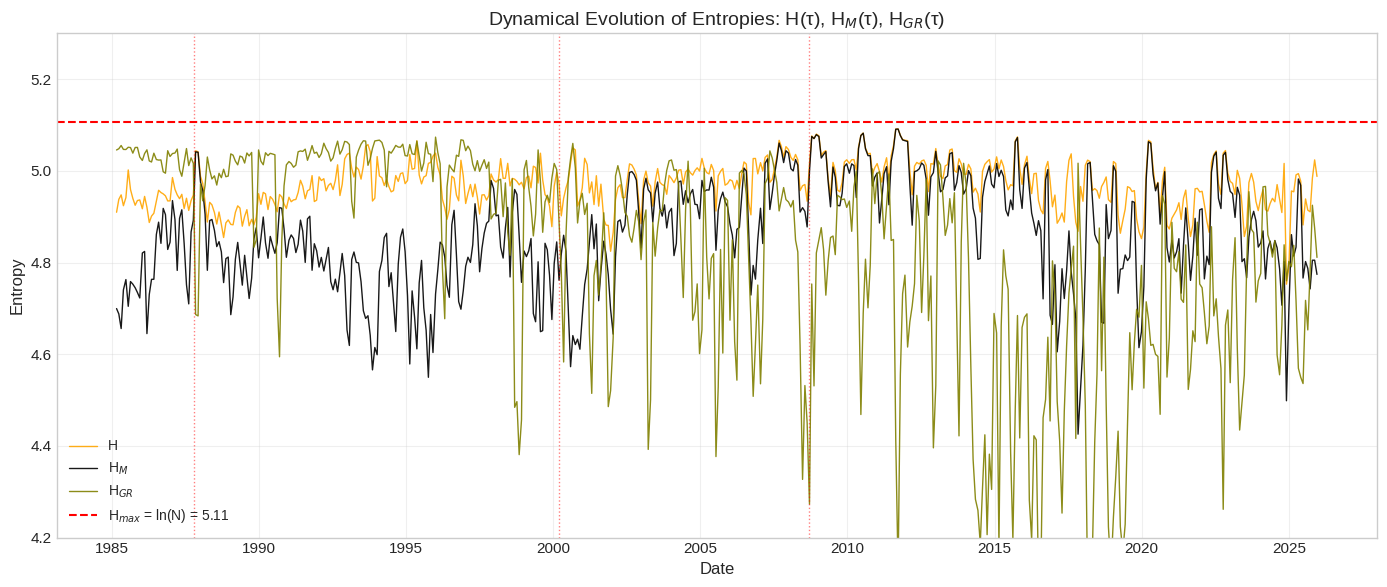

In [101]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the three entropies
ax.plot(results['date'], results['H'], color='orange', linewidth=1, label='H', alpha=0.9)
ax.plot(results['date'], results['H_M'], color='black', linewidth=1, label='H$_M$', alpha=0.9)
ax.plot(results['date'], results['H_GR'], color='olive', linewidth=1, label='H$_{GR}$', alpha=0.9)

H_max = results['H_max'].iloc[0]
ax.axhline(y=H_max, color='red', linestyle='--', linewidth=1.5, label=f'H$_{{max}}$ = ln(N) = {H_max:.2f}')

# crash markers
crash_dates = [
    ('1987-10-19', 'Black Monday'),
    ('2000-03-10', 'Dot-com'),
    ('2008-09-15', 'Lehman'),
]
for date, name in crash_dates:
    try:
        ax.axvline(pd.Timestamp(date), color='red', linestyle=':', alpha=0.5, linewidth=1)
    except:
        pass

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Entropy', fontsize=12)
ax.set_title('Dynamical Evolution of Entropies: H(τ), H$_M$(τ), H$_{GR}$(τ)', fontsize=14)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([4.2, 5.3])

plt.tight_layout()
plt.show()

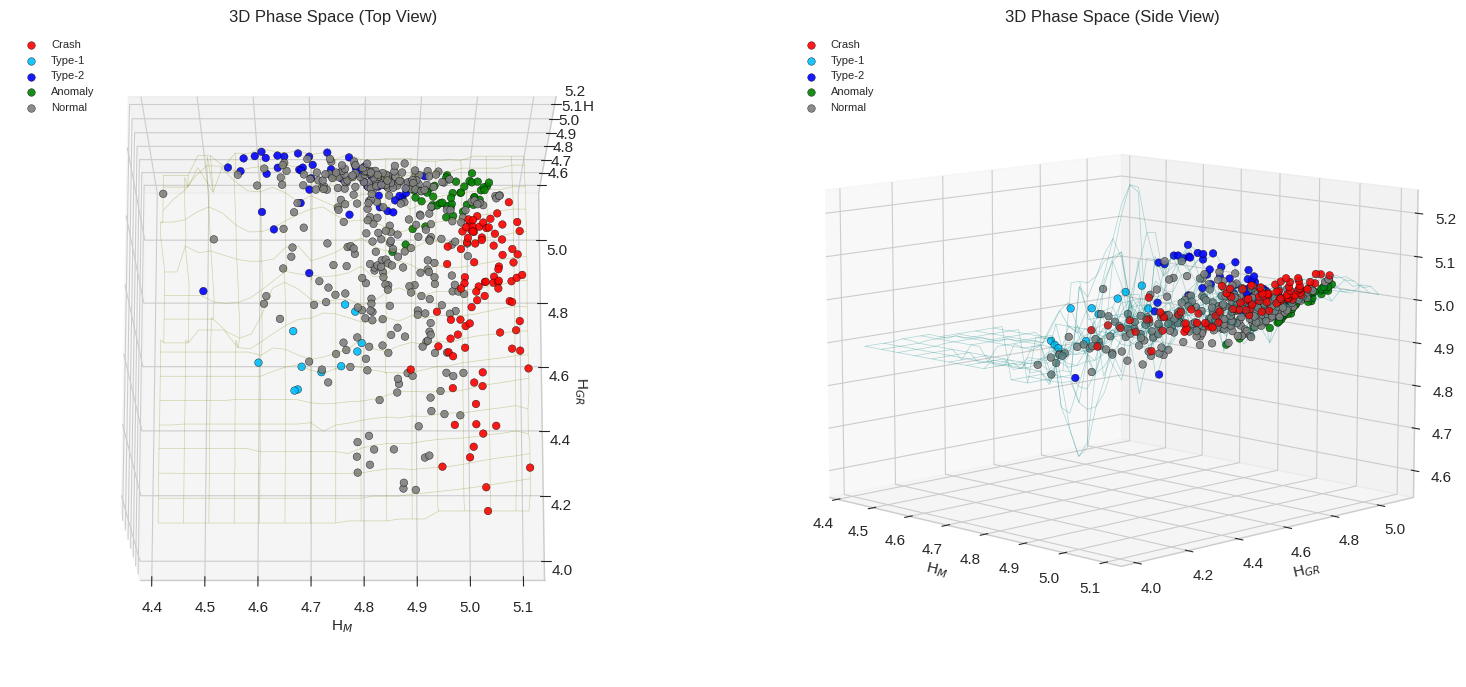

In [102]:
COLORS_3D = {
    'Crash': 'red',
    'Type-1': 'deepskyblue',
    'Type-2': 'blue',
    'Anomaly': 'green',
    'Normal': 'gray',
}

fig = plt.figure(figsize=(16, 7))


H_M_data = results_plot['H_M'].values
H_GR_data = results_plot['H_GR'].values
H_data = results_plot['H'].values

H_M_range = np.linspace(H_M_data.min(), H_M_data.max(), 30)
H_GR_range = np.linspace(H_GR_data.min(), H_GR_data.max(), 30)
H_M_mesh, H_GR_mesh = np.meshgrid(H_M_range, H_GR_range)

H_surface = griddata((H_M_data, H_GR_data), H_data, 
                     (H_M_mesh, H_GR_mesh), method='cubic')
H_surface_nearest = griddata((H_M_data, H_GR_data), H_data, 
                             (H_M_mesh, H_GR_mesh), method='nearest')
H_surface = np.where(np.isnan(H_surface), H_surface_nearest, H_surface)


ax1 = fig.add_subplot(121, projection='3d')

# Wireframe surface 
ax1.plot_wireframe(H_M_mesh, H_GR_mesh, H_surface, 
                   color='olive', alpha=0.3, linewidth=0.5, 
                   rstride=2, cstride=2)

for regime, color in COLORS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax1.scatter(results_plot.loc[mask, 'H_M'],
                   results_plot.loc[mask, 'H_GR'],
                   results_plot.loc[mask, 'H'],
                   c=color, s=30, alpha=0.9, label=regime,
                   edgecolors='k', linewidth=0.3, zorder=10)

ax1.set_xlabel('H$_M$', fontsize=11)
ax1.set_ylabel('H$_{GR}$', fontsize=11)
ax1.set_zlabel('H', fontsize=11)
ax1.set_title('3D Phase Space (Top View)', fontsize=12)
ax1.view_init(elev=75, azim=-90)
ax1.legend(loc='upper left', fontsize=8)

ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_wireframe(H_M_mesh, H_GR_mesh, H_surface, 
                   color='teal', alpha=0.3, linewidth=0.5,
                   rstride=2, cstride=2)

for regime, color in COLORS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax2.scatter(results_plot.loc[mask, 'H_M'],
                   results_plot.loc[mask, 'H_GR'],
                   results_plot.loc[mask, 'H'],
                   c=color, s=30, alpha=0.9, label=regime,
                   edgecolors='k', linewidth=0.3, zorder=10)

ax2.set_xlabel('H$_M$', fontsize=11)
ax2.set_ylabel('H$_{GR}$', fontsize=11)
ax2.set_zlabel('H', fontsize=11)
ax2.set_title('3D Phase Space (Side View)', fontsize=12)
ax2.view_init(elev=15, azim=-50)
ax2.legend(loc='upper left', fontsize=8)
ax2.view_init(elev=10, azim=-45)

plt.tight_layout()
plt.show()

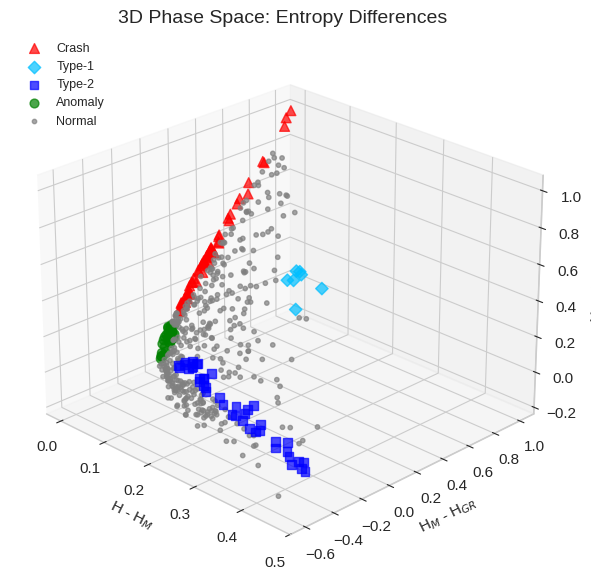

In [103]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

results_plot = results.copy()

H_HM_low = results_plot['abs_H_minus_HM'].quantile(0.15)
H_HM_high = results_plot['abs_H_minus_HM'].quantile(0.85)
H_HGR_low = results_plot['abs_H_minus_HGR'].quantile(0.15)
H_HGR_high = results_plot['abs_H_minus_HGR'].quantile(0.85)

results_plot['phase_regime'] = 'Normal'
crash_mask = (results_plot['abs_H_minus_HM'] < H_HM_low) & \
             (results_plot['abs_H_minus_HGR'] > results_plot['abs_H_minus_HGR'].quantile(0.5))
results_plot.loc[crash_mask, 'phase_regime'] = 'Crash'
type1_mask = (results_plot['abs_H_minus_HM'] > H_HM_high) & \
             (results_plot['abs_H_minus_HGR'] > H_HGR_high)
results_plot.loc[type1_mask, 'phase_regime'] = 'Type-1'
type2_mask = (results_plot['abs_H_minus_HM'] > results_plot['abs_H_minus_HM'].quantile(0.5)) & \
             (results_plot['abs_H_minus_HGR'] < H_HGR_low)
results_plot.loc[type2_mask, 'phase_regime'] = 'Type-2'
anomaly_mask = (results_plot['abs_H_minus_HM'] < results_plot['abs_H_minus_HM'].quantile(0.3)) & \
               (results_plot['abs_H_minus_HGR'] < results_plot['abs_H_minus_HGR'].quantile(0.3))
results_plot.loc[anomaly_mask, 'phase_regime'] = 'Anomaly'

# Markers and colors
MARKERS_3D = {
    'Crash': ('^', 'red', 50),
    'Type-1': ('D', 'deepskyblue', 40),
    'Type-2': ('s', 'blue', 40),
    'Anomaly': ('o', 'green', 40),
    'Normal': ('o', 'gray', 10),
}

for regime, (marker, color, size) in MARKERS_3D.items():
    mask = results_plot['phase_regime'] == regime
    if mask.any():
        ax.scatter(results_plot.loc[mask, 'H_minus_HM'],
                  results_plot.loc[mask, 'HM_minus_HGR'],
                  results_plot.loc[mask, 'H_minus_HGR'],
                  marker=marker, c=color, s=size, alpha=0.7, label=regime)

ax.set_xlabel('H - H$_M$', fontsize=11)
ax.set_ylabel('H$_M$ - H$_{GR}$', fontsize=11)
ax.set_zlabel('H - H$_{GR}$', fontsize=11)
ax.set_title('3D Phase Space: Entropy Differences', fontsize=14)
ax.legend(loc='upper left', fontsize=9)
ax.view_init(elev=25, azim=-45)

plt.tight_layout()
plt.show()

In [104]:
results_plot = results.copy()
results_plot = results_plot.reset_index(drop=True)

# Compute thresholds 
H_HM_25 = results_plot['abs_H_minus_HM'].quantile(0.25)
H_HM_35 = results_plot['abs_H_minus_HM'].quantile(0.35)
H_HM_50 = results_plot['abs_H_minus_HM'].quantile(0.50)
H_HM_80 = results_plot['abs_H_minus_HM'].quantile(0.80)
H_HGR_20 = results_plot['abs_H_minus_HGR'].quantile(0.20)
H_HGR_35 = results_plot['abs_H_minus_HGR'].quantile(0.35)
H_HGR_50 = results_plot['abs_H_minus_HGR'].quantile(0.50)
H_HGR_80 = results_plot['abs_H_minus_HGR'].quantile(0.80)

# Phase space regime classification 
results_plot['phase_regime'] = 'Normal'
results_plot.loc[(results_plot['abs_H_minus_HM'] < H_HM_25) & 
                 (results_plot['abs_H_minus_HGR'] > H_HGR_50), 'phase_regime'] = 'Crash'
results_plot.loc[(results_plot['abs_H_minus_HM'] > H_HM_80) & 
                 (results_plot['abs_H_minus_HGR'] > H_HGR_80), 'phase_regime'] = 'Type-1'
results_plot.loc[(results_plot['abs_H_minus_HM'] > H_HM_50) & 
                 (results_plot['abs_H_minus_HGR'] < H_HGR_20), 'phase_regime'] = 'Type-2'
results_plot.loc[(results_plot['abs_H_minus_HM'] < H_HM_35) & 
                 (results_plot['abs_H_minus_HGR'] < H_HGR_35) & 
                 (results_plot['phase_regime'] == 'Normal'), 'phase_regime'] = 'Anomaly'

# Known crash events
CRASH_EVENTS = {
    '1987-10-19': 'Black Monday',
    '1997-10-27': 'Asian Crisis',
    '2000-03-10': 'Dot-com',
    '2001-09-11': '9/11',
    '2008-09-15': 'Lehman',
    '2010-05-06': 'Flash Crash',
    '2011-08-08': 'Aug 2011',
    '2015-08-24': 'China Crisis',
    '2020-02-20': 'COVID',
}


crash_periods = results_plot[results_plot['phase_regime'] == 'Crash'][['date', 'abs_H_minus_HM', 'abs_H_minus_HGR']]

print("="*80)
print("PHASE SPACE 'CRASH' REGIME DETECTIONS")
print("(LOW |H-H_M| AND HIGH |H-H_GR| simultaneously)")
print("="*80)
print(f"\nTotal epochs classified as 'Crash': {len(crash_periods)} out of {len(results_plot)}")
print(f"\nCrash periods detected:")
print(crash_periods.to_string())



for event_date, event_name in CRASH_EVENTS.items():
    event_ts = pd.Timestamp(event_date)

    date_diffs = (results_plot['date'] - event_ts).abs()
    event_idx = date_diffs.idxmin()
    
    start_idx = max(0, event_idx - 2)
    end_idx = min(len(results_plot) - 1, event_idx + 2)
    
    window = results_plot.iloc[start_idx:end_idx + 1]
    detected = 'Crash' in window['phase_regime'].values
    
    status = "✓ DETECTED" if detected else "✗ NOT DETECTED"
    regimes = window['phase_regime'].tolist()
    print(f"{event_name:15s} ({event_date}): {status}  [Regimes: {' → '.join(regimes)}]")

PHASE SPACE 'CRASH' REGIME DETECTIONS
(LOW |H-H_M| AND HIGH |H-H_GR| simultaneously)

Total epochs classified as 'Crash': 91 out of 515

Crash periods detected:
          date  abs_H_minus_HM  abs_H_minus_HGR
34  1987-11-06        0.002267         0.357146
35  1987-12-07        0.001147         0.358109
171 1998-09-10        0.022369         0.497612
220 2002-08-06        0.018808         0.156732
221 2002-09-04        0.014291         0.168369
222 2002-10-02        0.011893         0.128552
228 2003-03-26        0.015203         0.581542
229 2003-04-24        0.015204         0.466053
231 2003-06-20        0.024489         0.162045
242 2004-05-05        0.024772         0.152815
284 2007-09-06        0.006004         0.153999
291 2008-03-28        0.010991         0.186820
292 2008-04-25        0.011629         0.200849
297 2008-09-17        0.017347         0.743284
298 2008-10-15        0.001208         0.322929
299 2008-11-12        0.000075         0.539604
300 2008-12-11        0

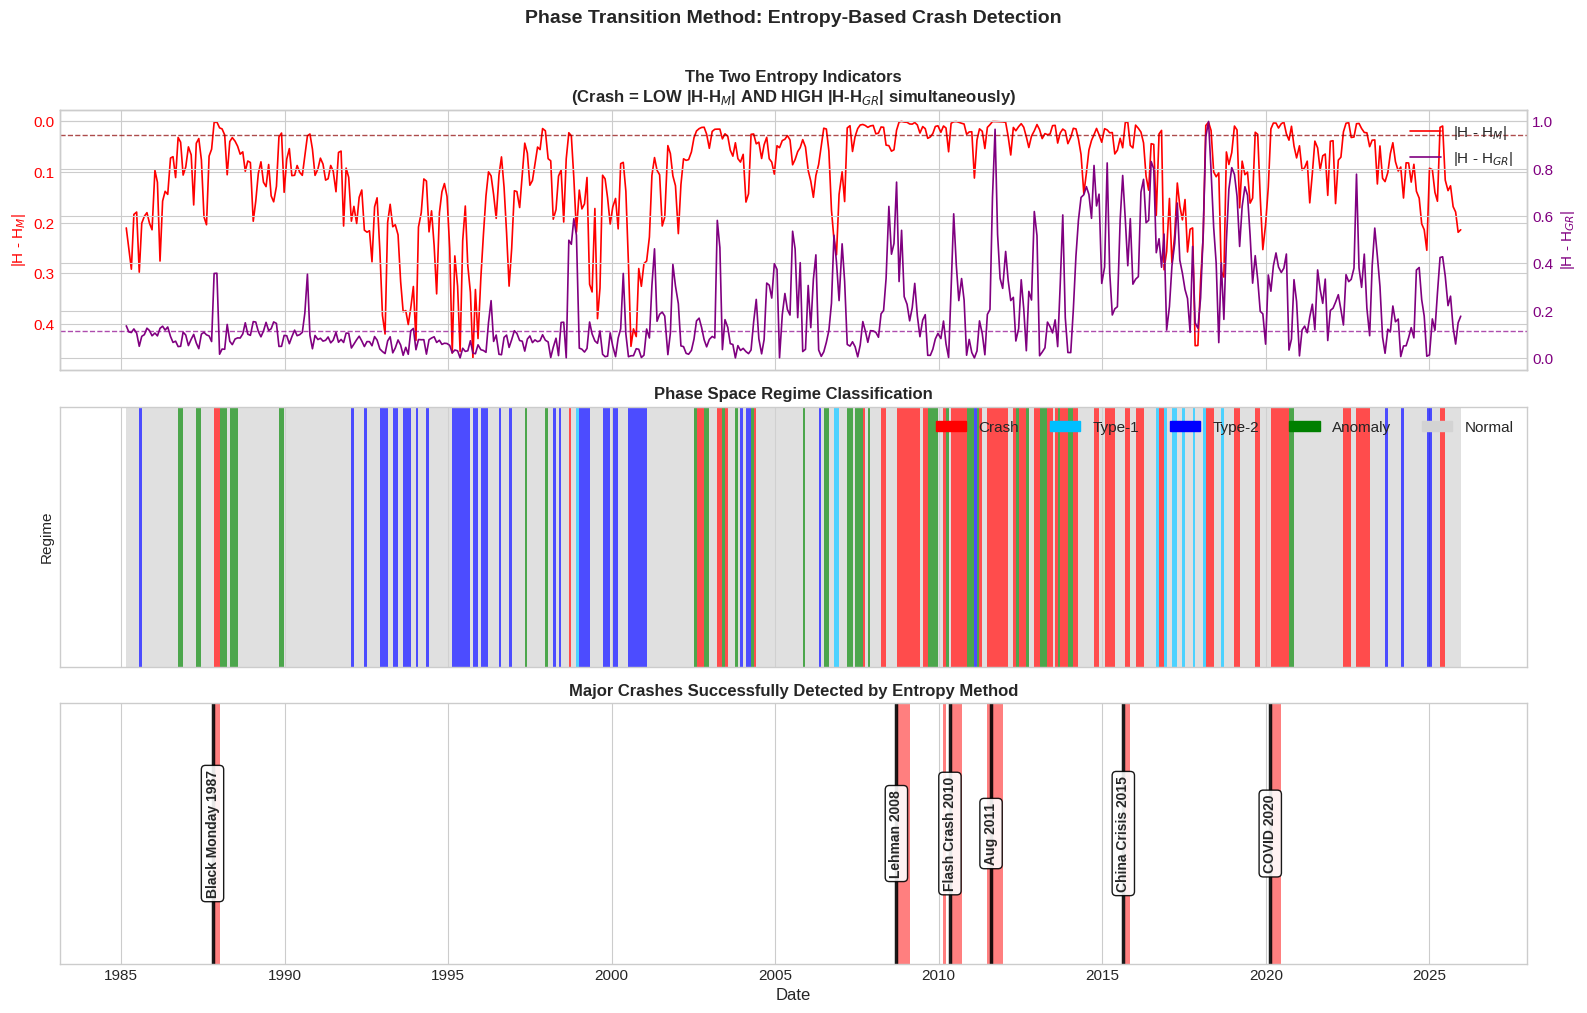

In [105]:
WELL_DETECTED_CRASHES = {
    '1987-10-19': 'Black Monday 1987',
    '2008-09-15': 'Lehman 2008',
    '2010-05-06': 'Flash Crash 2010',
    '2011-08-08': 'Aug 2011',
    '2015-08-24': 'China Crisis 2015',
    '2020-02-20': 'COVID 2020',
}


def is_near_event(epoch_date, events_dict, days_threshold=120):
    for event_date in events_dict.keys():
        event_ts = pd.Timestamp(event_date)
        if abs((epoch_date - event_ts).days) < days_threshold:
            return True
    return False

results_plot['near_known_crash'] = results_plot['date'].apply(
    lambda d: is_near_event(d, WELL_DETECTED_CRASHES, days_threshold=120)
)

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

dates = results_plot['date']

# Panel 1: The TWO entropy indicators 
ax1 = axes[0]
ax1.plot(dates, results_plot['abs_H_minus_HM'], 'r-', linewidth=1.2, label='|H - H$_M$|')
ax1.axhline(H_HM_25, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax1.set_ylabel('|H - H$_M$|', fontsize=11, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.invert_yaxis()

ax1_twin = ax1.twinx()
ax1_twin.plot(dates, results_plot['abs_H_minus_HGR'], 'purple', linewidth=1.2, label='|H - H$_{GR}$|')
ax1_twin.axhline(H_HGR_50, color='darkmagenta', linestyle='--', linewidth=1, alpha=0.7)
ax1_twin.set_ylabel('|H - H$_{GR}$|', fontsize=11, color='purple')
ax1_twin.tick_params(axis='y', labelcolor='purple')

ax1.set_title('The Two Entropy Indicators\n(Crash = LOW |H-H$_M$| AND HIGH |H-H$_{GR}$| simultaneously)', 
              fontsize=12, fontweight='bold')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Panel 2: Phase Space Regime 
ax2 = axes[1]
regime_colors = {'Crash': 'red', 'Type-1': 'deepskyblue', 'Type-2': 'blue', 'Anomaly': 'green', 'Normal': 'lightgray'}

for i in range(len(results_plot) - 1):
    regime = results_plot.iloc[i]['phase_regime']
    color = regime_colors[regime]
    ax2.axvspan(dates.iloc[i], dates.iloc[i+1], alpha=0.7, color=color, linewidth=0)

ax2.set_ylabel('Regime', fontsize=11)
ax2.set_yticks([])
ax2.set_title('Phase Space Regime Classification', fontsize=12, fontweight='bold')

patches = [mpatches.Patch(color=color, label=regime) for regime, color in regime_colors.items()]
ax2.legend(handles=patches, loc='upper right', ncol=5)

# Panel 3: ONLY red patches near well-detected crashes
ax3 = axes[2]
ax3.set_facecolor('white')

for i in range(len(results_plot) - 1):
    regime = results_plot.iloc[i]['phase_regime']
    near_known = results_plot.iloc[i]['near_known_crash']
    
    if regime == 'Crash' and near_known:
        ax3.axvspan(dates.iloc[i], dates.iloc[i+1], alpha=0.5, color='red', linewidth=0)


for event_date, event_name in WELL_DETECTED_CRASHES.items():
    event_ts = pd.Timestamp(event_date)
    if dates.min() <= event_ts <= dates.max():
        ax3.axvline(event_ts, color='black', linestyle='-', linewidth=2.5, alpha=0.9)
        ax3.annotate(event_name, xy=(event_ts, 0.5), xytext=(0, 0), 
                    textcoords='offset points', fontsize=10, rotation=90, 
                    ha='center', va='center', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.9))

ax3.set_ylabel('', fontsize=11)
ax3.set_yticks([])
ax3.set_ylim(0, 1)
ax3.set_title('Major Crashes Successfully Detected by Entropy Method', 
              fontsize=12, fontweight='bold')

axes[-1].set_xlabel('Date', fontsize=12)
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))

plt.suptitle('Phase Transition Method: Entropy-Based Crash Detection', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()



In [106]:
# Summary statistics by regime
print("="*70)
print("SUMMARY STATISTICS BY REGIME")
print("="*70)

for regime in ['normal', 'crash', 'bubble', 'type-1']:
    subset = results[results['regime'] == regime]
    if len(subset) > 0:
        print(f"\n{regime.upper()} (n={len(subset)}):")
        print(f"  H:          mean={subset['H'].mean():.4f}, std={subset['H'].std():.4f}")
        print(f"  H_M:        mean={subset['H_M'].mean():.4f}, std={subset['H_M'].std():.4f}")
        print(f"  H_GR:       mean={subset['H_GR'].mean():.4f}, std={subset['H_GR'].std():.4f}")
        print(f"  |H - H_M|:  mean={subset['abs_H_minus_HM'].mean():.4f}")
        print(f"  |H - H_GR|: mean={subset['abs_H_minus_HGR'].mean():.4f}")
        print(f"  μ (corr):   mean={subset['mu'].mean():.4f}, std={subset['mu'].std():.4f}")

SUMMARY STATISTICS BY REGIME

NORMAL (n=430):
  H:          mean=4.9704, std=0.0507
  H_M:        mean=4.8609, std=0.1210
  H_GR:       mean=4.8167, std=0.2429
  |H - H_M|:  mean=0.1094
  |H - H_GR|: mean=0.2059
  μ (corr):   mean=0.2636, std=0.1358

CRASH (n=24):
  H:          mean=4.9732, std=0.0612
  H_M:        mean=4.9180, std=0.1019
  H_GR:       mean=4.8158, std=0.2221
  |H - H_M|:  mean=0.0552
  |H - H_GR|: mean=0.2250
  μ (corr):   mean=0.3448, std=0.1768

BUBBLE (n=60):
  H:          mean=4.9732, std=0.0462
  H_M:        mean=4.8662, std=0.0987
  H_GR:       mean=4.8243, std=0.1710
  |H - H_M|:  mean=0.1069
  |H - H_GR|: mean=0.1650
  μ (corr):   mean=0.2400, std=0.0905

TYPE-1 (n=1):
  H:          mean=4.9781, std=nan
  H_M:        mean=4.6852, std=nan
  H_GR:       mean=4.4543, std=nan
  |H - H_M|:  mean=0.2928
  |H - H_GR|: mean=0.5237
  μ (corr):   mean=0.1791, std=nan
